# Практическая работа по распознаванию речи #4: <br> Поиск наилучшей гипотезы распознавания
Задача распознавания речи состоит в поиске наиболее вероятной словной гипотезы по имеющемуся звуковому сигналу. Используя теорему Байеса, формулировку задачи можно написать так:
$$ W^* = \underset{W}{argmax} {P(W|O)} =  \underset{W}{argmax} \sum_i^N{(\log{P(O|w_i)} + \log{P(w_i|w_{i-1}, w_{i-2},..))}}$$
Где:
* $O$ - звук
* $W$ - словная гипотеза распознавания
* $W^*$ - лучшая гипотеза распознавания
* $P(W|O)$ - вероятность гипотезы распознавания при условии наблюдения $O$
* $N$ - количество слов в гипотезе
* $w_i$ - i'ое слово в гипотезе
* $P(O|w_i)$ - акустическое правдоподобие слова (выводится из предсказания акустической моделью)
* $P(w_i|w_{i-1}, w_{i-2},..)$ - языковая вероятность слова при условии контекста (предсказывается языковой моделью)


В прошлых лабораторных работах были изучены акустическая и языковая модели. Акустическая модель предсказывает вероятность принадлежности кадра некоему акустическому классу (фонеме). Языковая модель предсказывает априорную вероятность последовательности слов. Пришло время разобраться, как соединить эти части в одну систему и получить итоговый результат распознавания.





### Основная часть (14 баллов) данной практической работы состоит из двух частей:
* знакомство с Weighted Finite State Transducer (WFST)
* WFST декодинг в ASR системе

### Дополнительная часть
* тюнинг параметров beam search (2 балла)

## Полезные ссылки:
* Наиболее популярная библиотека WFST - [OpenFst](https://www.openfst.org/twiki/bin/view/FST/WebHome)
* Библиотека для визуализации - [graphviz](https://graphviz.readthedocs.io/en/stable/manual.html)
* Алгоритм обхода графа в ширину - [BFS](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D0%B1%D1%85%D0%BE%D0%B4_%D0%B2_%D1%88%D0%B8%D1%80%D0%B8%D0%BD%D1%83)

In [1]:
!python --version

Python 3.12.3


In [2]:
!pip install graphviz kenlm kaldiio jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.4/427.4 kB 3.3 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 6.4 MB/s eta 0:00:00
  Created wheel for kenlm: filename=kenlm-0.2.0-cp312-cp312-linux_x86_64.whl size=591276 sha256=d58e60fc0ac2ef0bdf0309f3976772457ccb6269298c0b0f2e1980694a6ad6e6
  Stored in directory: /home/karysheva@ad.speechpro.com/.cache/pip/wheels/af/a6/d3/2c25d05460423097487a041df185dc263d8f3dcd62438148c6
Successfully built kenlm


In [3]:
import numpy as np
import time
import os
import abc

from typing import List, Dict, Union, Set, Any, Optional, Tuple
from tqdm.auto import tqdm
from collections import defaultdict
from pathlib import Path
from dataclasses import dataclass

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import graphviz
import kenlm
import jiwer
from kaldiio import ReadHelper

/home/karysheva@ad.speechpro.com/miniconda3/envs/ml_labs/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Weighted Finite State Transducer (WFST)



Из определения в wiki [Weighted Finite State Transducer (Взвешенный конечный автомат с выходом)](https://en.wikipedia.org/wiki/Finite-state_transducer) следует, что главная задача FST - это переводить символы из входного алфавита в соответствующие им символы из выходного алфавита. Например, с помощью FST можно перевести последовательность фонем в последовательность слов. Конечный автомат будет менять свое состояние при обработке последовательности входных символов (фонем). Когда он соберет из входных фонем корректную транскрипцию слова, то выдаст это слово на выход.

Однако не всегда можно однозначно перевести последовательность фонем в слова (некоторые слова произносятся одинаково, а пишутся по-разному), поэтому для распознавания речи надо использовать не простой FST, а взвешенный. WFST позволяет не только перевести входные символы в выходные, но и оценить вес такого перевода. Чем больше вес, тем хуже гипотеза.  

Напишем собственную реализацию WFST.


### AbstractWFST
AbstractWFST -- это базовый интерфейс нашего WFST. В нем заданы основные методы, через которые мы будем работать с wfst  
* get_start - возвращаяет стартовое состояние конечного автомата.
* final_score - вес завершения работы в данном состоянии. В некоторых состояниях завершить обработку невозможно, в таких случаях final weight  будет равен бесконечности.
*  transduce - совершает переход из текущего состояния в следующее, соответствующее переходу по символу ilabel. Возвращает выходной символ, вес перехода и следующее состояние.  






In [4]:
class AbstractWFST(abc.ABC):
    def __init__(self):
        pass

    @abc.abstractmethod
    def get_start(self) -> Any:
        """Return start state"""

    @abc.abstractmethod
    def final_score(self, state: Any) -> float:
        """is the state final? If true return negative log likelihood of the finalization. otherwise return inf"""

    @abc.abstractmethod
    def transduce(self, state: Any, ilabel: str) -> Tuple[Tuple[str, float, Any]]:
        """Transduce ilabel to olabel.
        return all available olabels for this state and ilabel pair
        return type - ((olabel1, weight1, nextstate1),
                       ((olabel1, weight1, nextstate1),
                       ...)"""

### SymbolsMap

Для того, чтобы задать WFST, первым делом нам понадобятся таблицы входных и выходных символов. Для задания таблиц будем использовать класс SymbolsMap. Данный класс служит для маппинга символов на индексы и обратно.

In [5]:
class SymbolsMap:
    def __init__(self, id2symbol: Optional[Dict[int, str]] = None, symbol2id: Optional[Dict[str, int]] = None):
        assert id2symbol is not None or symbol2id is not None, f"One id2symbol or symbol2id must be not None"
        assert id2symbol is None or symbol2id is None, f"Only one One id2symbol or symbol2id can be not None"
        if id2symbol is None:
            self.id2symbol = {i:s for s,i in symbol2id.items()}
        elif isinstance(id2symbol, dict):
            self.id2symbol = id2symbol
        elif isinstance(id2symbol, list):
            self.id2symbol = {i:s for i, s in enumerate(id2symbol)}
        else:
            raise RuntimeError(f"unknown type {type(id2symbol)=}")

        if symbol2id is None:
            self.symbol2id = {s:i for i, s in self.id2symbol.items()}
        else:
            self.symbol2id = symbol2id

        assert self.id2symbol[0] == '<eps>', f"wrong {self.id2symbol}"

    def get_id(self, symbol: str):
        return self.symbol2id[symbol]

    def get_symbol(self, id: int):
        return self.id2symbol[id]

    @classmethod
    def from_file(cls, fname):
        """read symbols table from file
        format:
            word id
            word2 id2
            ...
        """
        with open(fname) as f:
            s2i = {s:int(i) for s, i in map(str.split, f.readlines())}
        return cls(symbol2id=s2i)

### Arc и ILabelIndexedArcs
Переходы внутри FST будем описывать с помощью класса, инкапсулирующего информацию о входном/выходном индексе символа, весе перехода и следующем состоянии FST. Поскольку дуги мы будем хранить отдельно для каждого состояния, информация о текущем состоянии в дуге не нужна.

Для быстрого выбора нужной дуги создадим специальную коллекцию ILabelIndexedArcs. Данная коллекция хранит дуги таким образом, чтобы выбор дуги по входному символу осуществлялся за O(1).


In [6]:
@dataclass
class Arc:
    """Arc in WFST"""
    ilabel: int
    olabel: int
    weight: float
    nextstate: Any

class ILabelIndexedArcs:
    def __init__(self, arcs: Optional[List[Arc]] = None):
        self.ilabel2arclist = defaultdict(list)
        if arcs is not None:
            for arc in arcs:
                self.add_arc(arc)

    def add_arc(self, arc: Arc):
        self.ilabel2arclist[arc.ilabel].append(arc)

    def get_arcs_by_ilabel(self, ilabel: int):
        return self.ilabel2arclist[ilabel]

    def arcs(self) -> List[Arc]:
        """Return all arcs"""
        all_arcs = []
        # TODO
        # реализуйте функцию, которая возвращает все дуги, хранящиеся в данной коллекции
        for arcs_list in self.ilabel2arclist.values():
            all_arcs.extend(arcs_list)
        # !!!!!!!!!!!!
        return all_arcs

    def __str__(self):
        return "ILabelIndexedArcs([" + ", ".join(f"{a}" for a in self.arcs()) + "])"

    def __repr__(self):
        return str(self)

In [7]:
# test 1.a
def test_ILabelIndexedArcs():
    # проверка что arcs работает правильно
    arcs = [Arc(i, -i, i/100, i+100) for i in range(10)]
    c = ILabelIndexedArcs(arcs)
    arcs2 = c.arcs()

    assert len(arcs) == len(arcs2), f"{len(arcs)=}, {len(arcs2)=}\n{arcs} != {c.arcs()}"
    for a in arcs2:
        assert a in arcs, f"{a=} not in {arcs=}"
    print('Test 1.a passed')
test_ILabelIndexedArcs()

Test 1.a passed


### WFST
Все готово для создания взвешенного конечного автомата. Класс WFST состоит из таблицы входных и выходных символов, списка состояний и коллекции дуг для каждого, а также множества финальных состояний.

In [8]:
class WFST(AbstractWFST):
    def __init__(self,
                 isymbols: Optional[SymbolsMap] = None,
                 osymbols: Optional[SymbolsMap] = None):
        self.start = 0
        self.states = [0]
        # состояния, в которых может завершиться декодирование без какого либо штрафа
        self.final_states = set()
        self.isymbols = isymbols
        self.osymbols = osymbols
        self.state2arcs = defaultdict(ILabelIndexedArcs)

    def get_start(self):
        """return start state"""
        return self.start

    def final_score(self, state_id: int):
        """return the weight of decoding completion in state_id"""
        """is the state final? If true return negative log likelihood of the finalization. otherwise return inf"""
        # TODO
        # верните вес завершения декодирования в state_id
        if state_id in self.final_states:
            return 0.0
        else:
            return float('inf')
        # !!!!!!!!!!!!!!!!!!!

    def transduce(self, state, ilabel: str) -> Tuple[Tuple[str, float, int]]:
        """transitions wfst to next state by 'ilabel' input symbol, except when the input symbol is <eps>.
        Returns all possible output results as a tuple of triples (olabel, weight, nextstate)."""
        assert self.isymbols is not None and self.osymbols is not None, f"Cannot transduce w/o both symbols tables"
        if ilabel == '<eps>':
            # skip <eps> input
            return ((ilabel, 0, state), )
        label_id = self.isymbols.get_id(ilabel)
        # TODO
        # верните все возможные результаты перехода из текущего состояния по входу ilabel
        # результат должен выглядеть так: tuple(("слово", 0.1, 2), ("другоеслово", 10, 4), ...)
        arcs = self.state2arcs[state].get_arcs_by_ilabel(label_id)
        results = []
        for arc in arcs:
            results.append((self.osymbols.get_symbol(arc.olabel), arc.weight, arc.nextstate))
        # !!!!!!!!!!!!
        return tuple(results)

    def set_final(self, state: int):
        """sets the final weight for the state to zero"""
        # TODO добавьте возможность завершать декодирование в state
        self.final_states.add(state)
        # !!!!!!!!!!!

    def new_state(self):
        """Create new state id and return it"""
        # TODO
        # добавьте в конечный автомат новое состояние и верните его id
        state_id = self.states[-1] + 1
        self.states.append(state_id)
        # !!!!!!!!
        return state_id

    def add_arc(self, state_from: int, arc: Arc):
        """adds a new arc for this state"""
        # TODO
        # добавьте в конечный автомат новых переход arc, выходящий из state_from
        self.state2arcs[state_from].add_arc(arc)
        # !!!!!!!!!!!!!!!!!!

    def to_dot(self):
        """Visualize the WFST"""
        dot = graphviz.Digraph()
        for s in self.states:
            dot.node(str(s))
        for state_from, arcs_container in self.state2arcs.items():
            for arc in arcs_container.arcs():
                il = self.isymbols.get_symbol(arc.ilabel) if self.isymbols is not None else arc.ilabel
                ol = self.osymbols.get_symbol(arc.olabel) if self.osymbols is not None else arc.olabel
                dot.edge(str(state_from), str(arc.nextstate), label=f"{il}:{ol}:{arc.weight:.2f}")
        return dot


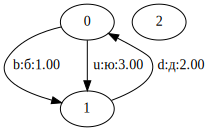

test 1.b passed


In [10]:
# test 1.b
def test_WFST():
    en_l = SymbolsMap(id2symbol=['<eps>', 'b', 'd', 'u'])
    ru_l = SymbolsMap(id2symbol=['<eps>', 'ю', 'б', 'д'])

    # create first transducer
    en2ru = WFST(isymbols=en_l, osymbols=ru_l)
    # new_state
    en2ru_final = en2ru.new_state()
    assert en2ru_final == 1 , f'start - zero, next state - one, next - two ...'
    assert en2ru.new_state() == 2, f'start - zero, next state - one, next - two ...'
    en2ru.set_final(en2ru_final)
    en2ru.add_arc(en2ru.get_start(), Arc(1, 2, 1.0, en2ru_final))
    en2ru.add_arc(en2ru_final, Arc(2, 3, 2.0, en2ru.get_start()))
    en2ru.add_arc(en2ru.get_start(), Arc(3, 1, 3.0, en2ru_final))
    # you can use this line to visualize
    display.display(en2ru.to_dot())

    # final_score # set_final
    assert en2ru.final_score(en2ru.get_start()) == float('inf')
    assert en2ru.final_score(en2ru_final) == 0
    en2ru.set_final(en2ru.get_start())
    assert en2ru.final_score(en2ru_final) == en2ru.final_score(en2ru.get_start()) == 0


    # transduce # add_arc
    assert en2ru.transduce(en2ru.get_start(), 'd') == tuple() , "Cannot transduce 'd' from start state. output must be zero len tuple"
    assert en2ru.transduce(en2ru.get_start(), 'b') == (('б', 1.0, en2ru_final), ) , "Arc(1, 2, 1.0, en2ru_final)"
    assert en2ru.transduce(en2ru.get_start(), 'u') == (('ю', 3.0, en2ru_final), ) , "Arc(3, 1, 3.0, en2ru_final)"
    assert en2ru.transduce(en2ru_final, 'd') == (('д', 2.0, en2ru.get_start()), ) , "Arc(2, 3, 2.0, en2ru.get_start())"

    print('test 1.b passed')
test_WFST()

## wfst композиция


Над WFST определен большой набор различных операций, реализация большинства из которых является сложной алгоритмической задачей. Важной для распознавания речи операцией является [композиция](https://www.openfst.org/twiki/bin/view/FST/ComposeDoc) набора различных wfst.

OpenFST дает следующее определение композиции:

"This operation computes the composition of two transducers. If A transduces string x to y with weight a and B transduces y to z with weight b, then their composition transduces string x to z with weight a ⊗ b."

Другими словами, результатом композиции является wfst, применение которого к входной последовательности даст такой же результат, как и последовательное применение композируемых wfst.

Хорошим примером композиции различных WFST является граф распознавания в гибридных системах распознавания речи. Такой граф является результатом композиции четырех wfst:
* H - Hidden Markov Model wfst (переводит акустические классы, предсказанные с помощью AM, в трифоны)
* С - Context-dependency transducer (переводит трифоны (тройки (leftcontext,phone,rightcontext)) в фонемы)
* L - lexicon (переводит фонемы в слова)
* G - ngram lm (оценивает вероятность последовательностей слов)

Итого граф распознавания можно выразить с помощью следующей формулы:
$$ HCLG = H⊗C⊗L⊗G $$
где ⊗ - оператор композиции двух wfst. Подробнее про граф распознавания можно почитать в [документации к фреймворку kaldi](https://kaldi-asr.org/doc/graph.html)


Композиция позволяет объединить много обработчиков в один большой граф, что несомненно является большим плюсом для построения продакшн решений. Но у такого подхода есть и минусы - процесс подготовки графа очень сложен и требует множества оптимизаций. Это усложняет любые эксперименты и модификации системы. В данной работе мы не будем реализовывать честную композицию графа, а будем считать композицию "On the Fly". То есть сделаем обертку, реализующую интерфейс AbstractWFST, состоянием которой будет Tuple состояний всех композируемых wfst, а метод transduce будет последовательно проходить через эти wfst. Тем самым, по определению композиции, наш класс будет эквивалентен честной композиции.  



In [11]:
class OnTheFlyCompose(AbstractWFST):
    def __init__(self, wfsts: List[AbstractWFST]):
        # !!!Attention!!! wfsts - это лист AbstractWFST, а не WFST.
        # Для работы с wfsts истользуйте только методы из AbstractWFST
        self.wfsts = wfsts

    def get_start(self):
        return tuple(fst.get_start() for fst in self.wfsts)

    def final_score(self, state: Tuple[Any]):
        assert len(state) == len(self.wfsts)
        # TODO
        # посчитайте финальный скор для state
        # результат композиции может завершить обработку только в тех стейтах, где все wfsts будут в финальных состояниях
        final_score = 0.0
        for state, wfst in zip(state, self.wfsts):
            final_score += wfst.final_score(state)
        return final_score
        # !!!!!!!!!!!!!!!!!!!!!

    def _transduce(self, state: Tuple[Any], ilabel: str) -> List[Tuple[List[str], float, List[int]]]:
        assert len(self.wfsts) == len(state)
        # Найдите все возможные гипотезы перевода ilabel с помощью композиции всех self.wfsts
        # Последовательно пройдите через все self.wfsts, расширяя список гипотез и дополняя гипотезы новыми слоями
        # Верните результат в виде списка гипотез.
        # Каждая гипотеза содержит три элемента:
        #   0. список символов со ВСЕХ прошедших слоев композиции
        #   1. суммарный вес гипотезы
        #   2. список состояний, в которые перешли self.wfsts

        # Одна стартовая гипотеза. Корень для всех гипотез.
        # Еще никакой wfst не применен, символ только ilabel, вес стартовый, стейтов еще нет.
        hyps_per_layer = [([ilabel], 0, [])]
        for wfst, s in zip(self.wfsts, state):
            new_hyps = []
            # TODO
            # примените fst.transduce ко всем гипотезам из hyps_per_layer
            # постепенно разветвляя их и сохраняя в new_hyp
            # на вход подайте выход последнего из уже обработаных слоев
            for hyp_label, hyp_weight, hyp_state in hyps_per_layer:
                transitions = wfst.transduce(s, hyp_label[-1])
                for out_label, weight, next_state in transitions:
                    new_hypothesis = (
                        hyp_label + [out_label],
                        hyp_weight + weight,
                        hyp_state + [next_state]
                    )
                    new_hyps.append(new_hypothesis)
            # !!!!!!!!!
            hyps_per_layer = new_hyps

        return hyps_per_layer

    def transduce(self, state: Tuple[Any], ilabel: str):
        hyps_per_layer = self._transduce(state, ilabel)
        # выходной символ transduce в композиции - это выходной символ самого последнего wfst
        return tuple((ls[-1], w, tuple(ss)) for ls, w, ss in hyps_per_layer)


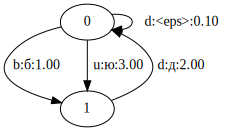

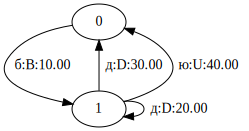

Test 1.c passed


In [12]:
def test_OnTheFlyCompose():
    en_l = SymbolsMap(id2symbol=['<eps>', 'b', 'd', 'u'])
    ru_l = SymbolsMap(id2symbol=['<eps>', 'ю', 'д', 'б'])
    en_U = SymbolsMap(id2symbol=['<eps>', 'B', 'D', 'U'])
    ru_U = SymbolsMap(id2symbol=['<eps>', 'Ю', 'Д', 'Б'])

    # create first transducer
    en2ru = WFST(isymbols=en_l, osymbols=ru_l)
    en2ru_final = en2ru.new_state()
    en2ru.set_final(en2ru_final)
    en2ru.add_arc(en2ru.get_start(), Arc(1, 3, 1.0, en2ru_final))
    en2ru.add_arc(en2ru_final, Arc(2, 2, 2.0, en2ru.get_start()))
    en2ru.add_arc(en2ru.get_start(), Arc(2, 0, 0.1, en2ru.get_start()))
    en2ru.add_arc(en2ru.get_start(), Arc(3, 1, 3.0, en2ru_final))
    # you can use this line to visualize
    display.display(en2ru.to_dot())

    # OnTheFlyCompose одного fst работает так же как и этот fst
    comp = OnTheFlyCompose([en2ru])
    for s in (0, 1):
        for il in 'bdu':
            hyps1 = en2ru.transduce(s, il)
            hyps2 = comp.transduce((s,), il)
            for h in hyps2:
                # only one state
                assert len(h[2]) == 1, f"{hyps2=}"
            hyps2_flatten = tuple((l, w, ss[0]) for l,w,ss in hyps2)
            assert hyps1 == hyps2_flatten, f"{hyps1=} {hyps2_flatten=}"

        scores = [float('inf'), 0]
        your_score = comp.final_score((s,))
        assert your_score == scores[s], f"Your score = {your_score}, correct = {scores[s]}"

    # create second transducer
    ru2en = WFST(isymbols=ru_l, osymbols=en_U)
    ru2en_final = ru2en.new_state()
    ru2en.set_final(ru2en_final)
    ru2en.add_arc(ru2en.get_start(), Arc(3, 1, 10.0, ru2en_final))
    ru2en.add_arc(ru2en_final, Arc(2, 2, 20.0, ru2en_final))
    ru2en.add_arc(ru2en_final, Arc(2, 2, 30.0, ru2en.get_start()))
    ru2en.add_arc(ru2en_final, Arc(1, 3, 40.0, ru2en.get_start()))

    # you can use this line to visualize
    display.display(ru2en.to_dot())

    # композиция двух работает как последовательное применение каждого
    comp = OnTheFlyCompose([en2ru, ru2en])
    hyps = comp.transduce((0, 0), 'b')
    assert hyps == (('B', 11.0, (1, 1)), ) , f"{hyps =}"
    hyps = comp.transduce((1, 1), 'd')
    assert hyps == (('D', 22.0, (0, 1)), ('D', 32.0, (0, 0))) , f"{hyps =}"
    hyps = comp.transduce((0, 1), 'd')
    assert hyps == (('<eps>', 0.1, (0, 1)), ) , f"{hyps =}"
    # Проверка правильности расчетов final_score
    your_score = comp.final_score((0, 0))
    assert your_score == float('inf'), f"Your score = {your_score}, correct = {float('inf')}"
    your_score = comp.final_score((0, 1))
    assert your_score == float('inf'), f"Your score = {your_score}, correct = {float('inf')}"
    your_score = comp.final_score((1, 0))
    assert your_score == float('inf'), f"Your score = {your_score}, correct = {float('inf')}"
    your_score = comp.final_score((1, 1))
    assert your_score == 0, f"Your score = {your_score}, correct = {0}"
    print('Test 1.c passed')


test_OnTheFlyCompose()

# 2. WFST декодинг в ASR системе
Отлично, код WFST готов, теперь необходимо собрать граф распознавания и написать поиск наилучшей гипотезы




In [13]:
# Сначала подготовим нужные нам таблицы символов
AM_PHONES = {0: 'pau', 1: 'aa', 2: 'ae', 3: 'ah', 4: 'ao', 5: 'aw', 6: 'ax', 7: 'ax-h', 8: 'axr', 9: 'ay', 10: 'b',
             11: 'bcl', 12: 'ch', 13: 'd', 14: 'dcl', 15: 'dh', 16: 'dx', 17: 'eh', 18: 'el', 19: 'em', 20: 'en',
             21: 'eng', 22: 'er', 23: 'ey', 24: 'f', 25: 'g', 26: 'gcl', 27: 'hh', 28: 'hv', 29: 'ih', 30: 'ix',
             31: 'iy', 32: 'jh', 33: 'k', 34: 'kcl', 35: 'l', 36: 'm', 37: 'n', 38: 'ng', 39: 'nx', 40: 'ow',
             41: 'oy', 42: 'p', 43: 'pcl', 44: 'q', 45: 'r', 46: 's', 47: 'sh', 48: 't', 49: 'tcl', 50: 'th',
             51: 'uh', 52: 'uw', 53: 'ux', 54: 'v', 55: 'w', 56: 'y', 57: 'z', 58: 'zh'}

# таблица фонем для wfst
def create_phones_txt(fname='exp/phones.txt'):
    fname = Path(fname)
    fname.parent.mkdir(exist_ok=True, parents=True)
    with open(fname, 'w') as f:
        f.write('<eps> 0\n') # !! shift all ids by one !!
        for i, p in sorted(AM_PHONES.items()):
            f.write(f'{p} {i+1}\n')
create_phones_txt()


In [21]:
!pip install kaggle

In [22]:
!kaggle datasets download -d mfekadu/darpa-timit-acousticphonetic-continuous-speech

Dataset URL: https://www.kaggle.com/datasets/mfekadu/darpa-timit-acousticphonetic-continuous-speech
License(s): copyright-authors
100% 828M/829M [00:10<00:00, 133MB/s]
100% 829M/829M [00:10<00:00, 85.5MB/s]


In [23]:
!unzip -o -q darpa-timit-acousticphonetic-continuous-speech.zip -d timit/

In [14]:
# Загрузим подготовленный лексикон из датасета
def load_lexicon_file(fname='timit/TIMITDIC.TXT', words_limit=-1):
    """generator running through the 'fname' phonetic dictionary
    yield (word: str, phones: List[str])"""
    num = 0
    with open(fname) as f:
        for line in map(str.strip, f.readlines()):
            if line.startswith(';'):
                continue
            word, trans, _ = line.split('/')
            # remove ~adj suffix
            word = word.split('~')[0].strip()
            # remove stress factor
            trans = [t[:-1] if t[-1].isdigit() else t for t in trans.split()]
            yield word, trans
            num += 1
            if words_limit == num:
                break

In [15]:
# подготовим таблицу слов
def create_words_txt(fname='exp/words.txt', dic_fname='timit/TIMITDIC.TXT'):
    fname = Path(fname)
    fname.parent.mkdir(exist_ok=True, parents=True)
    words = ['<eps>'] + [w for w, _ in sorted(load_lexicon_file(dic_fname))] + ['<s>', '</s>']
    with open(fname, 'w') as f:
        f.write(''.join(f'{w} {i}\n' for i, w in enumerate(words)))
create_words_txt()

# T transducer

Создадим первый wfst.

В гибридном пайплайне системы распознавания речи задача первых двух wfst (H и C) - это перевести предсказанные с помощью акустической модели классы в последовательность фонем. В нашем случае все значительно легче, так как АМ (из работы №3) уже учится предсказывать фонемы, поэтому мы не будем использовать HС трансдьюсеры.

В этой работе будет использоваться простой трасдьюсер T. Этот wfst нужен для преобразования вероятностей фонем, которые оценивает AM, в их правдоподобие. Используя теорему Баеса, сделать это преобразование легко. Надо просто добавить к скорам фонем их априорную вероятность.


T.wfst состоит из одного состояния и N петель, где N - это количество фонем. Каждая петля соответствует определенной фонеме и хранит логарифм ее априорной вероятности.

![image](resources/lab4/H_example.svg)

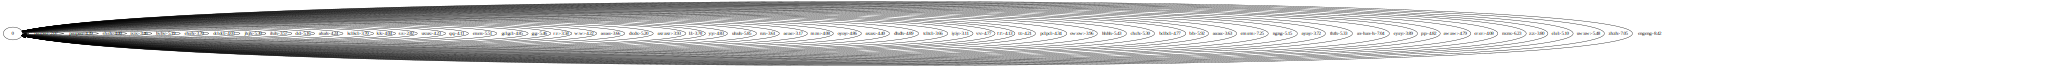

In [17]:
def create_t_wfst(prior_file='resources/lab4/phone.priors', phones_fname='exp/phones.txt'):
    """Create T.wfst. just transduce AM probability to AM likelihood (Bayes theorem)
    """
    symbols = SymbolsMap.from_file(phones_fname)
    t_fst = WFST(isymbols=symbols, osymbols=symbols)
    s = t_fst.get_start()
    t_fst.set_final(s)
    with open(prior_file) as f:
        for ph, prior in map(str.split, f.readlines()):
            log_prior = np.log(float(prior))
            ph_id = symbols.get_id(ph)
            t_fst.add_arc(s, Arc(ph_id, ph_id, log_prior, s))
    return t_fst
create_t_wfst().to_dot()

# L transducer

Lwfst - это WFST, который преобразует входные последовательности фонем в слова.

Например, `pau pau ae1 ae1 ae1 ae1 ae1 ae1 r pau pau pau y y y y eh1 s s s pau` -> `air yes`

Чтобы контролировать количество слов в выходной гипотезе, в L добавляется два веса:
* word_insertion_penalty - штраф за добавление слова
* stay_in_silence_penalty - штраф за пропуск паузы (фонемы pau)

Пример Lwfst, построенного для слов `'em` `-knacks`, с параметрами word_insertion_penalty=0.5, stay_in_silence_penalty=0.01

![image](./resources/lab4/L_example.svg)

Фонема паузы pau обрабатывается особым способом: L.fst может пропускать ее, не генерируя ничего на выходе. Также у окончания каждой транскрипции слова есть две отдельные дуги, возвращающие FST в стартовое состояние. Это нужно для того, чтобы была возможность как обработать подряд идущие дупликаты последней фонемы на конце слова, так и перейти в стартовое состояние всего по одной финальной фонеме.

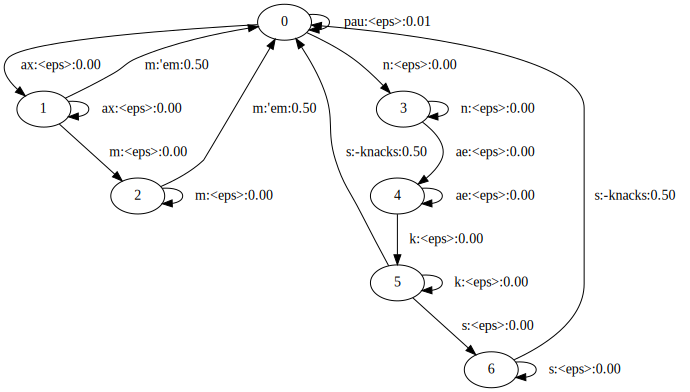

In [18]:
def create_Lwfst_from_file(dic_fname='timit/TIMITDIC.TXT',
                           phones_fname='exp/phones.txt',
                           words_fname='exp/words.txt',
                           words_limit=-1,
                           word_insertion_penalty=0.5,
                           stay_in_silence_penalty=0.01):
    isymbols = SymbolsMap.from_file(phones_fname)
    osymbols = SymbolsMap.from_file(words_fname)
    sil_id = isymbols.get_id('pau')
    l_wfst = WFST(isymbols=isymbols, osymbols=osymbols)
    start = l_wfst.get_start()
    ### Пропуск скольких угодно фонем тишины
    l_wfst.add_arc(start, Arc(sil_id, 0, stay_in_silence_penalty, start))
    # Стартовое состояние также является и финальным
    l_wfst.set_final(start)

    for word, trans in load_lexicon_file(dic_fname, words_limit=words_limit):
        tran_ids = [isymbols.get_id(t) for t in trans]
        word_id = osymbols.get_id(word)
        # TODO
        # Добавьте последовательные дуги в wfst, определяющие транскрипцию слова
        # Все дуги, кроме последней, на выходе имеют <eps>
        # Последняя дуга выводит word_id и возвращает конечный автомат в стартовое (оно же финальное) состояние
        # Каждая фонема может тянуться от 1 до inf кадров, поэтому помимо переходов в новое состояние, должны быть еще петли
        current_state = start
        for idx, tran_id in enumerate(tran_ids):
            new_state = l_wfst.new_state()
            l_wfst.add_arc(current_state, Arc(tran_id, 0, 0, new_state))
            l_wfst.add_arc(new_state, Arc(tran_id, 0, 0, new_state))
            if idx == len(tran_ids) - 1:
                l_wfst.add_arc(current_state, Arc(tran_id, word_id, word_insertion_penalty, start))
                l_wfst.add_arc(new_state, Arc(tran_id, word_id, word_insertion_penalty, start))
            current_state = new_state
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    return l_wfst
create_Lwfst_from_file(words_limit=2, word_insertion_penalty=0.5, stay_in_silence_penalty=0.01).to_dot()

In [19]:
def test_l_wfst():
    l_wfst = create_Lwfst_from_file(dic_fname='timit/TIMITDIC.TXT',
                                    word_insertion_penalty=1.0, stay_in_silence_penalty=0.01)
    start = l_wfst.get_start()
    hyps = l_wfst.transduce(start, 'pau')
    loop_hyp = [(l, w, s) for l, w, s in hyps if s == start]
    assert (len(loop_hyp) == 1
            and loop_hyp[0][0] == '<eps>'
            and loop_hyp[0][1] == 0.01), f"{hyps}\n skip pause test failed"
    # смотрим, что поданная на вход транскрипция корректно переводится в слово
    # количество подряд идущих одинаковых фонем постепенно увеличивается от одной до 6
    for i, (word, trans) in enumerate(tqdm(load_lexicon_file('timit/TIMITDIC.TXT', words_limit=100), total=100)):
        hyps = [('', 0, l_wfst.get_start()), ]
        # Breadth First Search
        for t in [t for t in trans for _ in range(i//20+1)]:
            # t repeated many times
            new_hyps = []
            for prev_l, prev_w, prev_s in hyps:
                new_hyps.extend([(f"{prev_l} {l}", prev_w + w, s) for l,w,s in l_wfst.transduce(prev_s, t)])
            hyps = new_hyps
        # choose only final hyp
        # ограничение веса нужно, чтобы отсечь гипотезы где комбинация других слов мапится на теже фонемы
        hyps = [(l, w, s) for l, w, s in hyps if l_wfst.final_score(s) != float('inf') and w == 1.0]

        assert len(hyps) == 1 or len(trans) == 1 , f"Test failed for word \"{word}\" {hyps=}"
        assert hyps[0][0].replace('<eps>', ' ').split() == [word], f"Test failed for word {word} {hyps=}"
        assert hyps[0][1] == 1.0, f"Test failed for word {word} {hyps=}"
        assert hyps[0][2] == start, f"Test failed for word {word} {hyps=}"
    print("test 2.a passed")
test_l_wfst()

100%|██████████| 100/100 [00:02<00:00, 47.65it/s]

test 2.a passed


# Поиск наилучшей гипотезы распознавания с помощью beam search

Для того, чтобы найти результат распознавания с помощью акустической модели и графа распознавания, надо выполнить поиск наилучшей гипотезы в графе. Для поиска лучшего пути будем использовать [лучевой поиск (Beam Search)](https://ru.wikipedia.org/wiki/%D0%9B%D1%83%D1%87%D0%B5%D0%B2%D0%BE%D0%B9_%D0%BF%D0%BE%D0%B8%D1%81%D0%BA). В основе этого алгоритма лежит обход графа в ширину, но на каждом шаге рассматриваются только наиболее "хорошие" гипотезы, а остальные уничтожаются. Такая эвристика позволяет значительно ускорить процесс декодирования, но не всегда находит наилучший путь.

In [20]:
@dataclass(order=True)
class Hypothesis:
    # накопленный штраф гипотезы
    score: float
    # до какого кадра из входной последовательности дошла гипотеза
    time: int
    # накопленная последовательность слов
    words: List[str]
    # состояние графа декодирования
    state: Any


### HypothesesKeeper
Реализуем специальную коллекцию, которая хранит все гипотезы распознавания и применяет прунинг (удаление ненужных гипотез).
Прунинг делится на два типа:
#### State pruning
Eсли мы можем дойти до состояния X в момент времени T несколькими способами, то для дальнейшей обработки достаточно только наилучшего пути до состояния X. Эта гипотеза гарантированно будет лучше всех других гипотез, проходящих через точку (X, T).
#### Beam pruning
Эвристика лучевого поиска. Отсекаем все гипотезы, которые хуже, чем лучшая текущая гипотеза плюс beam_size. Вероятность того, что гипотезы с сильно худшим весом вдруг станут наилучшими, крайне мала, поэтому такая эвристика работает достаточно хорошо.


In [21]:
class HypothesesKeeper:
    def __init__(self, init_hyps: List[Hypothesis] = [], beam_size=10):
        self.state2hyp = {h.state: h for h in init_hyps}
        self.beam_size = beam_size
        if len(self.state2hyp) == 0:
            self.set_best(None, float('inf'))
        else:
            min_hyp = min(self.state2hyp.values())
            self.set_best(min_hyp.state, min_hyp.score)

    def set_best(self, state, score):
        self.best_state = state
        self.best_score = score

    def get_best_hyp(self) -> Hypothesis:
        """return the best hyp based on self.best_state"""
        # TODO
        # верните лучшую гипотезу
        return self.state2hyp[self.best_state]
        # !!!!!!!!!!

    def prune(self):
        self.state2hyp = {s:h for s, h in self.state2hyp.items() if not self.is_prunned_by_beam(h.score)}

    def tolist(self) -> List[Hypothesis]:
        """Return all hypotheses. Apply beam pruning"""
        # TODO
        # верните все гипотезы, которые находятся в луче поиска
        return [h for h in self.state2hyp.values() if not self.is_prunned_by_beam(h.score)]
        # !!!!!!!!!!!!!!!!!

    def is_prunned_by_beam(self, score: float):
        """Return true if score greater than beam"""
        # TODO
        # верните True, если значение score находится вне луча поиска
        return score > self.best_score + self.beam_size
        #!!!!!!!!!!!!!!!!

    def is_prunned_by_state(self, state, score):
        """Returns true if the keeper already has a hyp in the same state and the score of this hyp is lower"""
        # TODO
        # верните True, если state уже имеет гипотезу, со скором лучше чем score
        return state in self.state2hyp and self.state2hyp[state].score < score
        # !!!!!!!!!!!!!!!!!!!

    def append(self, hyp: Hypothesis):
        """Append new hyp into collection"""
        if self.is_prunned_by_beam(hyp.score) or self.is_prunned_by_state(hyp.state, hyp.score):
            return
        self.state2hyp[hyp.state] = hyp
        if hyp.score < self.best_score or self.best_state is None:
            self.set_best(hyp.state, hyp.score)

    def extend(self, hyps):
        if isinstance(hyps, HypothesesKeeper):
            hyps = hyps.tolist()
        for h in hyps:
            self.append(h)

    def __len__(self):
        return len(self.state2hyp)

    def __str__(self):
        return '[' + ",\n".join(map(str, self.tolist())) + ']'

    def describe(self):
        # TODO
        # посчитайте средний и максимальный скор хранящихся гипотез
        scores = [value.score for value in self.state2hyp.values()]
        mean_score = np.mean(scores)
        max_score = max(scores)
        # !!!!!!!
        return (
            f"{len(self)} hyps. "
            f"Best {self.get_best_hyp()}. "
            f"Mean score {mean_score:.2f}. "
            f"Max {max_score:.2f}"
        )

In [22]:
def test_hyp_keeper():
    hyps = HypothesesKeeper(beam_size=10)
    hyps.append(Hypothesis(10, 0, ['a'],  1))
    assert len(hyps) == 1 and hyps.best_state == 1 and hyps.best_score == 10, f"First append doesn't work well"
    hyps.append(Hypothesis(100, 0, ['err'], 2))
    assert len(hyps) == 1 and hyps.best_state == 1 and hyps.best_score == 10, f"Append didn't prune the input"

    hyps.append(Hypothesis(11, 0, ['b'], 2))
    assert len(hyps) == 2 and hyps.best_state == 1 and hyps.best_score == 10, f"Append doesn't work well"
    hyps.append(Hypothesis(12, 0, ['err2'], 2))
    assert len(hyps) == 2 and hyps.state2hyp[2].score == 11, f"Append didn't prune the input"

    hyps.append(Hypothesis(0, 0, ['c'], 3))
    assert hyps.best_state == 3 and hyps.best_score == 0, f"Append didn't update best_* attributes"

    hyps_list = hyps.tolist()
    assert len(hyps_list) == 2, f"tolist didn't prune the output"

    hyp = hyps.get_best_hyp()
    assert hyp == Hypothesis(0, 0, ['c'], 3), f"{hyp=}"
    print("test 2.b passed!")
test_hyp_keeper()

test 2.b passed!


In [24]:
class BeamSearcher:
    def __init__(self, am2phone_mapping, graph: AbstractWFST, beam_size=3):
        self.am2phone_mapping = am2phone_mapping
        self.graph = graph
        self.beam_size = beam_size

    def decode(self, phonemes_nll: np.ndarray):
        """
        Decoding input phonemes negative loglikelihood into word level hypthesis
        phonemes_logprobs.shape is (Time, num_phones)
        """
        parent_hyps = HypothesesKeeper(init_hyps=[Hypothesis(0, -1, [], self.graph.get_start())],
                                       beam_size=self.beam_size)
        pbar = tqdm(phonemes_nll)
        for new_time, frame_dist in enumerate(pbar):
            new_hyps = HypothesesKeeper(beam_size=self.beam_size)
            for parent_hyp in parent_hyps.tolist():
                assert parent_hyp.time + 1 == new_time, f"Wrong time {new_time=}, \n{parent_hyp=}"
                # TODO
                # Продолжите гипотезу parent_hyp с помощью всех фонем и их вероятностей из frame_dist
                # соханите новые гипотезы в new_hyps
                # words гипотез не должен содержать <eps>
                # score гипотезы равен сумме скора родителя, phone_nll и веса от transduce по графу
                for i, phone_nll in enumerate(frame_dist):
                    input_label = self.am2phone_mapping[i]
                    for output_label, weight, next_state in self.graph.transduce(parent_hyp.state, input_label):
                        if output_label == "<eps>":
                            words = parent_hyp.words
                        else:
                            words = parent_hyp.words + [output_label]
                        new_hyp = Hypothesis(score = parent_hyp.score + phone_nll + weight,
                                             time = new_time,
                                             words = words,
                                             state = next_state)
                        new_hyps.append(new_hyp)
                # !!!!!!!!

            new_hyps.prune()
            parent_hyps = new_hyps
            statictic_str = parent_hyps.describe()
            pbar.set_description(statictic_str, refresh=False)
        # TODO
        # сформируйте список финальных гипотез
        # пройдитесь по parent_hyps и добавьте ко всем гипотезам финальный вес
        final_hyps = HypothesesKeeper(beam_size=self.beam_size)
        for parent_hyp in parent_hyps.tolist():
            final_score = parent_hyp.score + self.graph.final_score(parent_hyp.state)
            final_hyp = Hypothesis(score = final_score, 
                                   time = parent_hyp.time, 
                                   words = parent_hyp.words, 
                                   state = parent_hyp.state)
            final_hyps.append(final_hyp)
        # !!!!!!!!!!!!!!!


        print(f"Found {len(final_hyps)} hypotheses")
        best_hyp = final_hyps.get_best_hyp()
        return best_hyp

In [25]:
def test_beam_search():

    graph = WFST(isymbols=SymbolsMap(id2symbol=['<eps>', 'pau', 'A', 'B']),
                 osymbols=SymbolsMap(id2symbol=['<eps>', 'err', '_', 'a', 'b']))
    s = graph.new_state()
    graph.add_arc(0, Arc(2, 3, 2.0, s))
    graph.add_arc(0, Arc(3, 4, 3.0, s))
    graph.add_arc(s, Arc(1, 2, 1.0, 0))
    graph.set_final(s)

    searcher = BeamSearcher(am2phone_mapping={0: 'pau', 1: 'A', 2: 'B'}, graph=graph, beam_size=10)
    #                   p  A  B
    logits = np.array([[-1, -1, -1],
                       [0, 0, 0],
                       [-100, -100, -100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((-1+2) + (-0+1) + (-100+2) , 2, ['a', '_', 'a'], s), best_hyp
    logits = np.array([[1, 4, 1],
                       [100, 0, 0],
                       [100, 100, 100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((1+3) + (100+1) + (100+2) , 2, ['b', '_', 'a'], s), best_hyp

    searcher.graph.add_arc(0, Arc(2, 0, 5.0, 0))
    logits = np.array([[1, 2, 0],
                       [10, 0, 0],
                       [100, 100, 100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((2+5) + (0+5) + (100+2) , 2, ['a'], s), best_hyp

    logits = np.array([[1, 20, 4], # beam pruning must remove A-loop hypothesis
                       [1000, 0, 0],
                       [100, 100, 100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((4+3) + (1000+1) + (100+2) , 2, ['b', '_', 'a'], s), best_hyp

    searcher.graph.add_arc(0, Arc(3, 0, -1, 0))
    logits = np.array([[1, 2, 0],
                       [10, 0, 0],
                       [100, 100, 100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((0-1) + (0-1) + (100+2) , 2, ['a'], s), best_hyp

    print(f"Test 2.c passed")
test_beam_search()

1 hyps. Best Hypothesis(score=-96.0, time=2, words=['a', '_', 'a'], state=1). Mean score -96.00. Max -96.00: 100%|██████████| 3/3 [00:00<00:00, 10856.70it/s]


Found 1 hypotheses


1 hyps. Best Hypothesis(score=207.0, time=2, words=['b', '_', 'a'], state=1). Mean score 207.00. Max 207.00: 100%|██████████| 3/3 [00:00<00:00, 11597.15it/s]


Found 1 hypotheses


2 hyps. Best Hypothesis(score=110.0, time=2, words=['a', '_'], state=0). Mean score 112.00. Max 114.00: 100%|██████████| 3/3 [00:00<00:00, 13443.28it/s]


Found 1 hypotheses


2 hyps. Best Hypothesis(score=1110.0, time=2, words=['b', '_', 'a'], state=1). Mean score 1111.50. Max 1113.00: 100%|██████████| 3/3 [00:00<00:00, 13443.28it/s]


Found 1 hypotheses


2 hyps. Best Hypothesis(score=97, time=2, words=[], state=0). Mean score 98.50. Max 100.00: 100%|██████████| 3/3 [00:00<00:00, 13203.48it/s]

Found 1 hypotheses
Test 2.c passed


### WFST представление нграмной языковой модели
Для подсчета языковой модели будем использовать библиотеку kenlm. Данная библиотека позволяет подсчитывать языковую вероятность с помощью нграмной языковой модели.

Создадим обертку над kenlm.Model, реализующую интерфейс AbstractWFST

In [26]:
class kenlmLikeWFST(AbstractWFST):
    """Оборачиваем kenlm в унифицированный интерфейс"""
    def __init__(self, lm: kenlm.Model, lmwt_factor=0.01):
        self.lm = lm
        self.lmwt_factor = lmwt_factor

    def get_start(self):
        state = kenlm.State()
        self.lm.BeginSentenceWrite(state)
        return state

    def final_score(self, state: kenlm.State):
        logprob = self.lm.BaseScore(state, "</s>", kenlm.State())
        return self._log10_to_nll(logprob)

    def _log10_to_nll(self, logprob):
        """переводим в negative натуральный логирифм """
        return - np.log(10**logprob)

    def transduce(self, state: kenlm.State, ilabel: str):
        assert isinstance(ilabel, str), ilabel
        if ilabel == '<eps>':
            # skip <eps> input
            return [('<eps>', 0, state), ]
        state2 = kenlm.State()
        logprob = self.lm.BaseScore(state, ilabel, state2)
        return [(ilabel, self.lmwt_factor * self._log10_to_nll(logprob), state2), ]


## Запускаем декодирование


In [28]:
# Заранее подготовленные negative log probability от модели из работы №3
with ReadHelper('ark:resources/lab4/test_am_nlogprobs.ark') as am_nlogprob_reader:
    am_nlogprobs = {uri: am_logprob  for uri, am_logprob in am_nlogprob_reader}

In [29]:
# Выбираем один пример для отладки пайплайна
example = am_nlogprobs['timit/data/TEST/DR1/FAKS0/SA1']
with open('timit/data/TEST/DR1/FAKS0/SA1.TXT') as f:
    example_ref = ' '.join(f.read().replace('.', ' ').split()[2:])
print(example_ref)

She had your dark suit in greasy wash water all year


In [30]:
t_fst = create_t_wfst()
l_fst = create_Lwfst_from_file(stay_in_silence_penalty=0.0, word_insertion_penalty=1.0)

In [31]:
# пробуем разные варианты
ASR = BeamSearcher(am2phone_mapping=AM_PHONES,
                   graph=OnTheFlyCompose([t_fst, l_fst]),
                   beam_size=0)
hyp = ASR.decode(example)
print(hyp, "WER: ", jiwer.wer(example_ref, ' '.join(hyp.words)))

# Hypothesis(score=inf, time=197, words=[], state=(0, 28541)) WER:  1.0

  0%|          | 0/198 [00:00<?, ?it/s]

1 hyps. Best Hypothesis(score=695.0641150122512, time=197, words=[], state=(0, 28541)). Mean score 695.06. Max 695.06: 100%|██████████| 198/198 [00:00<00:00, 574.52it/s]  

Found 1 hypotheses
Hypothesis(score=inf, time=197, words=[], state=(0, 28541)) WER:  1.0


In [32]:
ASR = BeamSearcher(am2phone_mapping=AM_PHONES,
                   graph=OnTheFlyCompose([t_fst, l_fst]),
                   beam_size=6)
hyp = ASR.decode(example)
print(hyp, "WER: ", jiwer.wer(example_ref, ' '.join(hyp.words)))

# Hypothesis(score=-634.8072872315479,
# time=197,
# words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'],
# state=(0, 0)) WER:  0.09090909090909091

  0%|          | 0/198 [00:00<?, ?it/s]

1 hyps. Best Hypothesis(score=-634.8072872315479, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0)). Mean score -634.81. Max -634.81: 100%|██████████| 198/198 [00:08<00:00, 22.79it/s]  

Found 1 hypotheses
Hypothesis(score=-634.8072872315479, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0)) WER:  0.09090909090909091


In [34]:
lm = kenlmLikeWFST(kenlm.LanguageModel('resources/lab4/3gram.arpa'), lmwt_factor=0.2)
ASR = BeamSearcher(am2phone_mapping=AM_PHONES,
                   graph=OnTheFlyCompose([t_fst, l_fst, lm]),
                   beam_size=6)
hyp = ASR.decode(example)
print(hyp, "WER: ", jiwer.wer(example_ref, ' '.join(hyp.words)))

# Hypothesis(score=-624.2866933483066,
# time=197,
# words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'],
# state=(0, 0, <kenlm.State object at 0x7fa93c7c1070>)) WER:  0.09090909090909091

Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-624.8311055262099, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5caf15bbb0>)). Mean score -624.83. Max -624.83: 100%|██████████| 198/198 [00:12<00:00, 16.08it/s]      

Found 1 hypotheses
Hypothesis(score=-624.2866933483066, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5caf15bbb0>)) WER:  0.09090909090909091


### финальное задание
Постройте графики зависимости WER на example и времени работы декодирования от таких параметров как:
* lmwt_factor
* stay_in_silence_penalty
* word_insertion_penalty
* beam

Выберите оптимальные по соотношению WER/time параметры.

In [76]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [36]:
parameters = {"lmwt_factor": [0.01, 0.1, 0.5],
              "stay_in_silence_penalty": [0.01, 0.1, 0.5],
              "word_insertion_penalty": [0.5, 0.25, 1.0],
              "beam_size": [10, 5, 2]}

keys = parameters.keys()
values = parameters.values()

combinations = list(itertools.product(*values))
combinations_dicts = [dict(zip(keys, combination)) for combination in combinations]

In [38]:
print(f"Количество комбинаций: {len(combinations_dicts)}")

Количество комбинаций: 81


In [40]:
results = {"lmwt_factor": [],
           "stay_in_silence_penalty": [],
           "word_insertion_penalty": [],
           "beam_size": [],
           "wer": [],
           "time": []}

for parameters_dict in tqdm(combinations_dicts, total=len(combinations_dicts)):
    t_fst = create_t_wfst()
    l_fst = create_Lwfst_from_file(stay_in_silence_penalty=parameters_dict["stay_in_silence_penalty"],
                                   word_insertion_penalty=parameters_dict["word_insertion_penalty"])
    lm = kenlmLikeWFST(kenlm.LanguageModel('resources/lab4/3gram.arpa'), lmwt_factor=parameters_dict["lmwt_factor"])
    ASR = BeamSearcher(am2phone_mapping=AM_PHONES,
                   graph=OnTheFlyCompose([t_fst, l_fst, lm]),
                   beam_size=parameters_dict["beam_size"])

    start_time = time.time()
    hyp = ASR.decode(example)
    end_time = time.time()

    results["lmwt_factor"].append(parameters_dict["lmwt_factor"])
    results["stay_in_silence_penalty"].append(parameters_dict["stay_in_silence_penalty"])
    results["word_insertion_penalty"].append(parameters_dict["word_insertion_penalty"])
    results["beam_size"].append(parameters_dict["beam_size"])
    results["wer"].append(jiwer.wer(example_ref, ' '.join(hyp.words)))
    results["time"].append(end_time - start_time)

  0%|          | 0/81 [00:00<?, ?it/s]Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
740 hyps. Best Hypothesis(score=-647.6329014459576, time=197, words=['she', 'had', 'you', 'earn', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'awe', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5cb4247630>)). Mean score -638.99. Max -637.69: 100%|██████████| 198/198 [02:30<00:00,  1.31it/s]
  1%|          | 1/81 [02:31<3:21:35, 151.19s/it]

Found 6 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-639.698670667037, time=197, words=['she', 'had', 'you', 'earn', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5caf545530>)). Mean score -639.70. Max -639.70: 100%|██████████| 198/198 [00:16<00:00, 11.67it/s] 
  2%|▏         | 2/81 [02:48<1:35:19, 72.40s/it] 

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-578.24619218306, time=197, words=['she', 'had', 'your', 'arc', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year', 'earth'], state=(0, 0, <kenlm.State object at 0x7f5cb672c3f0>)). Mean score -578.25. Max -578.25: 100%|██████████| 198/198 [00:05<00:00, 37.21it/s]
  4%|▎         | 3/81 [02:54<54:27, 41.89s/it]  

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
740 hyps. Best Hypothesis(score=-650.6329014459576, time=197, words=['she', 'had', 'you', 'earn', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'awe', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5c9e81f470>)). Mean score -642.00. Max -640.69: 100%|██████████| 198/198 [03:00<00:00,  1.10it/s]
  5%|▍         | 4/81 [05:54<2:04:00, 96.63s/it]Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75

Found 6 hypotheses


The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-642.698670667037, time=197, words=['she', 'had', 'you', 'earn', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5cb43d44f0>)). Mean score -642.70. Max -642.70: 100%|██████████| 198/198 [00:20<00:00,  9.55it/s] 
  6%|▌         | 5/81 [06:15<1:27:47, 69.31s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-604.7126087735777, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year', 'earth'], state=(0, 0, <kenlm.State object at 0x7f5c9f72b1f0>)). Mean score -604.71. Max -604.71: 100%|██████████| 198/198 [00:05<00:00, 36.83it/s]
  7%|▋         | 6/81 [06:21<59:35, 47.67s/it]  

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
740 hyps. Best Hypothesis(score=-641.8227089252016, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'awe', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5c97f6ac70>)). Mean score -633.18. Max -631.88: 100%|██████████| 198/198 [02:10<00:00,  1.52it/s]
  9%|▊         | 7/81 [08:31<1:32:15, 74.81s/it]

Found 6 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-633.888478146281, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5cb65d4270>)). Mean score -633.89. Max -633.89: 100%|██████████| 198/198 [00:13<00:00, 14.16it/s] 
 10%|▉         | 8/81 [08:46<1:07:34, 55.54s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-562.1884860428177, time=197, words=['she', 'had', 'your', 'arc', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year', 'earth'], state=(0, 0, <kenlm.State object at 0x7f5cb50a2cf0>)). Mean score -562.19. Max -562.19: 100%|██████████| 198/198 [00:05<00:00, 35.01it/s]
 11%|█         | 9/81 [08:51<48:02, 40.03s/it]  

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100

The ARPA file is missing <unk>.  Substituting log10 probability -100.
766 hyps. Best Hypothesis(score=-643.9429014459575, time=197, words=['she', 'had', 'you', 'earn', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'awe', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5c9d621570>)). Mean score -635.35. Max -633.97: 100%|██████████| 198/198 [02:40<00:00,  1.23it/s]
 12%|█▏        | 10/81 [11:33<1:31:37, 77.43s/it]

Found 6 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-635.918670667037, time=197, words=['she', 'had', 'you', 'earn', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5cb4ab5b70>)). Mean score -635.92. Max -635.92: 100%|██████████| 198/198 [00:17<00:00, 11.01it/s] 
 14%|█▎        | 11/81 [11:51<1:09:13, 59.33s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-575.09619218306, time=197, words=['she', 'had', 'your', 'arc', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year', 'earth'], state=(0, 0, <kenlm.State object at 0x7f5c9cddf8b0>)). Mean score -575.10. Max -575.10: 100%|██████████| 198/198 [00:05<00:00, 35.14it/s]
 15%|█▍        | 12/81 [11:57<49:32, 43.08s/it]  

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
766 hyps. Best Hypothesis(score=-646.9429014459575, time=197, words=['she', 'had', 'you', 'earn', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'awe', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5cb633ff30>)). Mean score -638.35. Max -636.97: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]
 16%|█▌        | 13/81 [15:03<1:37:59, 86.47s/it]

Found 6 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-638.918670667037, time=197, words=['she', 'had', 'you', 'earn', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5caf04abf0>)). Mean score -638.92. Max -638.92: 100%|██████████| 198/198 [00:20<00:00,  9.59it/s] 
 17%|█▋        | 14/81 [15:24<1:14:27, 66.68s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-601.5626087735778, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year', 'earth'], state=(0, 0, <kenlm.State object at 0x7f5c9da28730>)). Mean score -601.56. Max -601.56: 100%|██████████| 198/198 [00:05<00:00, 36.09it/s]
 19%|█▊        | 15/81 [15:30<53:08, 48.32s/it]  

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
766 hyps. Best Hypothesis(score=-638.1327089252014, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'awe', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5caffbea30>)). Mean score -629.53. Max -628.16: 100%|██████████| 198/198 [02:10<00:00,  1.52it/s]
 20%|█▉        | 16/81 [17:40<1:19:04, 72.99s/it]

Found 6 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-630.1084781462808, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5caffb94b0>)). Mean score -630.11. Max -630.11: 100%|██████████| 198/198 [00:14<00:00, 14.13it/s]
 21%|██        | 17/81 [17:54<59:01, 55.34s/it]  

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-559.1284860428177, time=197, words=['she', 'had', 'your', 'arc', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year', 'earth'], state=(0, 0, <kenlm.State object at 0x7f5cb4544af0>)). Mean score -559.13. Max -559.13: 100%|██████████| 198/198 [00:05<00:00, 34.75it/s]
 22%|██▏       | 18/81 [18:00<42:31, 40.51s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
767 hyps. Best Hypothesis(score=-627.9034897793366, time=197, words=['she', 'had', 'you', 'earn', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'awe', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5cb539f9f0>)). Mean score -619.70. Max -618.05: 100%|██████████| 198/198 [02:43<00:00,  1.21it/s]
 23%|██▎       | 19/81 [20:44<1:20:07, 77.54s/it]

Found 6 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100

The ARPA file is missing <unk>.  Substituting log10 probability -100.
1 hyps. Best Hypothesis(score=-619.118670667037, time=197, words=['she', 'had', 'you', 'earn', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5c9c173bf0>)). Mean score -619.12. Max -619.12: 100%|██████████| 198/198 [00:17<00:00, 11.05it/s] 
 25%|██▍       | 20/81 [21:03<1:00:44, 59.74s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-561.0961921830602, time=197, words=['she', 'had', 'your', 'arc', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year', 'earth'], state=(0, 0, <kenlm.State object at 0x7f5caf148f30>)). Mean score -561.10. Max -561.10: 100%|██████████| 198/198 [00:05<00:00, 34.38it/s]
 26%|██▌       | 21/81 [21:09<43:37, 43.62s/it]  

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
767 hyps. Best Hypothesis(score=-630.9034897793366, time=197, words=['she', 'had', 'you', 'earn', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'awe', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5c9d6bcff0>)). Mean score -622.70. Max -621.30: 100%|██████████| 198/198 [03:08<00:00,  1.05it/s]
 27%|██▋       | 22/81 [24:17<1:25:37, 87.08s/it]

Found 6 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100

The ARPA file is missing <unk>.  Substituting log10 probability -100.
1 hyps. Best Hypothesis(score=-622.118670667037, time=197, words=['she', 'had', 'you', 'earn', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5cb5d544b0>)). Mean score -622.12. Max -622.12: 100%|██████████| 198/198 [00:20<00:00,  9.82it/s] 
 28%|██▊       | 23/81 [24:37<1:04:51, 67.10s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-587.5626087735777, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year', 'earth'], state=(0, 0, <kenlm.State object at 0x7f5c9db3f430>)). Mean score -587.56. Max -587.56: 100%|██████████| 198/198 [00:05<00:00, 38.00it/s]
 30%|██▉       | 24/81 [24:43<46:10, 48.61s/it]  

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
766 hyps. Best Hypothesis(score=-622.0932972585805, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'awe', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5caf9cf1b0>)). Mean score -613.89. Max -612.52: 100%|██████████| 198/198 [02:05<00:00,  1.58it/s]
 31%|███       | 25/81 [26:49<1:07:00, 71.79s/it]

Found 6 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-613.3084781462809, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5cb4ad4c30>)). Mean score -613.31. Max -613.31: 100%|██████████| 198/198 [00:13<00:00, 14.78it/s]
 32%|███▏      | 26/81 [27:03<49:49, 54.36s/it]  

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-545.5284860428178, time=197, words=['she', 'had', 'your', 'arc', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year', 'earth'], state=(0, 0, <kenlm.State object at 0x7f5cb6a1b1b0>)). Mean score -545.53. Max -545.53: 100%|██████████| 198/198 [00:05<00:00, 36.66it/s]
 33%|███▎      | 27/81 [27:08<35:46, 39.75s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100

The ARPA file is missing <unk>.  Substituting log10 probability -100.
738 hyps. Best Hypothesis(score=-642.1337235342166, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5c9e852130>)). Mean score -633.49. Max -632.19: 100%|██████████| 198/198 [01:51<00:00,  1.78it/s]
 35%|███▍      | 28/81 [29:00<54:06, 61.25s/it]Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100


Found 4 hypotheses


The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-634.8991963788789, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5cafc10af0>)). Mean score -634.90. Max -634.90: 100%|██████████| 198/198 [00:12<00:00, 16.34it/s]
 36%|███▌      | 29/81 [29:12<40:20, 46.54s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-555.0494646915128, time=197, words=['she', 'had', 'your', 'arc', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year', 'earth'], state=(0, 0, <kenlm.State object at 0x7f5cafcecef0>)). Mean score -555.05. Max -555.05: 100%|██████████| 198/198 [00:05<00:00, 39.31it/s]
 37%|███▋      | 30/81 [29:17<29:02, 34.17s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
740 hyps. Best Hypothesis(score=-644.8837235342166, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5c9f1fc8b0>)). Mean score -636.24. Max -634.94: 100%|██████████| 198/198 [02:04<00:00,  1.59it/s]
 38%|███▊      | 31/81 [31:22<51:10, 61.41s/it]

Found 6 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100

The ARPA file is missing <unk>.  Substituting log10 probability -100.
1 hyps. Best Hypothesis(score=-637.6491963788789, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5c9c5f55b0>)). Mean score -637.65. Max -637.65: 100%|██████████| 198/198 [00:14<00:00, 13.91it/s]
 40%|███▉      | 32/81 [31:37<38:40, 47.35s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-565.5058721617498, time=197, words=['she', 'had', 'your', 'arc', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year', 'earth'], state=(0, 0, <kenlm.State object at 0x7f5caf1129b0>)). Mean score -565.51. Max -565.51: 100%|██████████| 198/198 [00:05<00:00, 37.32it/s]
 41%|████      | 33/81 [31:42<27:53, 34.86s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
738 hyps. Best Hypothesis(score=-636.6337235342166, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5cb43f6cb0>)). Mean score -627.99. Max -626.69: 100%|██████████| 198/198 [01:23<00:00,  2.38it/s]
 42%|████▏     | 34/81 [33:06<38:41, 49.39s/it]Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---

Found 4 hypotheses


1 hyps. Best Hypothesis(score=-629.3991963788789, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5caf8ab7f0>)). Mean score -629.40. Max -629.40: 100%|██████████| 198/198 [00:11<00:00, 17.74it/s]
 43%|████▎     | 35/81 [33:17<29:06, 37.96s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=359.79101330639867, time=197, words=['she', 'had', 'your', 'are'], state=(0, 7207, <kenlm.State object at 0x7f5caf1bcbb0>)). Mean score 359.79. Max 359.79: 100%|██████████| 198/198 [00:01<00:00, 114.58it/s]
 44%|████▍     | 36/81 [33:19<20:24, 27.21s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
764 hyps. Best Hypothesis(score=-638.4437235342165, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5c9db65270>)). Mean score -629.85. Max -628.48: 100%|██████████| 198/198 [01:53<00:00,  1.74it/s]
 46%|████▌     | 37/81 [35:13<39:04, 53.27s/it]

Found 4 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-631.1191963788787, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5c9d4cb4f0>)). Mean score -631.12. Max -631.12: 100%|██████████| 198/198 [00:11<00:00, 16.78it/s]
 47%|████▋     | 38/81 [35:25<29:19, 40.93s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-551.9894646915128, time=197, words=['she', 'had', 'your', 'arc', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year', 'earth'], state=(0, 0, <kenlm.State object at 0x7f5caf747230>)). Mean score -551.99. Max -551.99: 100%|██████████| 198/198 [00:05<00:00, 37.84it/s]
 48%|████▊     | 39/81 [35:31<21:12, 30.29s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
766 hyps. Best Hypothesis(score=-641.1937235342165, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5caf8658b0>)). Mean score -632.60. Max -631.23: 100%|██████████| 198/198 [02:06<00:00,  1.57it/s]
 49%|████▉     | 40/81 [37:37<40:23, 59.11s/it]Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---

Found 6 hypotheses


1 hyps. Best Hypothesis(score=-633.8691963788787, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5caff47830>)). Mean score -633.87. Max -633.87: 100%|██████████| 198/198 [00:14<00:00, 13.71it/s]
 51%|█████     | 41/81 [37:52<30:29, 45.75s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-562.4458721617499, time=197, words=['she', 'had', 'your', 'arc', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year', 'earth'], state=(0, 0, <kenlm.State object at 0x7f5cb42b6db0>)). Mean score -562.45. Max -562.45: 100%|██████████| 198/198 [00:05<00:00, 35.82it/s]
 52%|█████▏    | 42/81 [37:57<21:56, 33.76s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
764 hyps. Best Hypothesis(score=-632.9437235342165, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5cb5a758b0>)). Mean score -624.34. Max -622.98: 100%|██████████| 198/198 [01:24<00:00,  2.34it/s]
 53%|█████▎    | 43/81 [39:22<31:03, 49.05s/it]Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---

Found 4 hypotheses


1 hyps. Best Hypothesis(score=-625.6191963788787, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5cb62baef0>)). Mean score -625.62. Max -625.62: 100%|██████████| 198/198 [00:11<00:00, 17.61it/s] 
 54%|█████▍    | 44/81 [39:34<23:16, 37.74s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=362.4010133063985, time=197, words=['she', 'had', 'your', 'are'], state=(0, 7207, <kenlm.State object at 0x7f5caf45fb30>)). Mean score 362.40. Max 362.40: 100%|██████████| 198/198 [00:01<00:00, 109.00it/s]
 56%|█████▌    | 45/81 [39:36<16:13, 27.04s/it]Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substitut

Found 1 hypotheses


764 hyps. Best Hypothesis(score=-622.4043118675955, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5cb41ff7f0>)). Mean score -614.20. Max -612.84: 100%|██████████| 198/198 [01:52<00:00,  1.75it/s]
 57%|█████▋    | 46/81 [41:29<30:50, 52.88s/it]

Found 4 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-614.3191963788787, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5caf4de370>)). Mean score -614.32. Max -614.32: 100%|██████████| 198/198 [00:12<00:00, 16.37it/s]
 58%|█████▊    | 47/81 [41:41<23:04, 40.73s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-538.3894646915128, time=197, words=['she', 'had', 'your', 'arc', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year', 'earth'], state=(0, 0, <kenlm.State object at 0x7f5cb4fe67b0>)). Mean score -538.39. Max -538.39: 100%|██████████| 198/198 [00:05<00:00, 39.15it/s]
 59%|█████▉    | 48/81 [41:47<16:33, 30.11s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
766 hyps. Best Hypothesis(score=-625.1543118675955, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5cb5bf3cf0>)). Mean score -616.95. Max -615.59: 100%|██████████| 198/198 [02:07<00:00,  1.55it/s]
 60%|██████    | 49/81 [43:54<31:40, 59.39s/it]

Found 6 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-617.0691963788787, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5c9dbf0ab0>)). Mean score -617.07. Max -617.07: 100%|██████████| 198/198 [00:14<00:00, 13.73it/s]
 62%|██████▏   | 50/81 [44:09<23:45, 45.99s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-548.84587216175, time=197, words=['she', 'had', 'your', 'arc', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year', 'earth'], state=(0, 0, <kenlm.State object at 0x7f5cb5b219b0>)). Mean score -548.85. Max -548.85: 100%|██████████| 198/198 [00:05<00:00, 36.52it/s]
 63%|██████▎   | 51/81 [44:15<16:56, 33.90s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100

The ARPA file is missing <unk>.  Substituting log10 probability -100.
763 hyps. Best Hypothesis(score=-616.9043118675955, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5caf446a70>)). Mean score -608.70. Max -607.34: 100%|██████████| 198/198 [01:24<00:00,  2.33it/s]
 64%|██████▍   | 52/81 [45:40<23:48, 49.26s/it]

Found 3 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-608.8191963788787, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5cb60a6530>)). Mean score -608.82. Max -608.82: 100%|██████████| 198/198 [00:11<00:00, 17.95it/s]
 65%|██████▌   | 53/81 [45:51<17:40, 37.88s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=374.0010133063985, time=197, words=['she', 'had', 'your', 'are'], state=(0, 7207, <kenlm.State object at 0x7f5caf5ca830>)). Mean score 374.00. Max 374.00: 100%|██████████| 198/198 [00:01<00:00, 103.88it/s] 
 67%|██████▋   | 54/81 [45:53<12:13, 27.16s/it]Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substitu

Found 1 hypotheses


735 hyps. Best Hypothesis(score=-620.7578090949024, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5c9cb60470>)). Mean score -612.11. Max -610.82: 100%|██████████| 198/198 [00:31<00:00,  6.24it/s]
 68%|██████▊   | 55/81 [46:25<12:23, 28.59s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
2 hyps. Best Hypothesis(score=597.9001711504313, time=197, words=['she', 'had'], state=(0, 36310, <kenlm.State object at 0x7f5c9f71c370>)). Mean score 598.62. Max 599.33: 100%|██████████| 198/198 [00:01<00:00, 176.97it/s]
 69%|██████▉   | 56/81 [46:27<08:30, 20.43s/it]

Found 2 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100

The ARPA file is missing <unk>.  Substituting log10 probability -100.
1 hyps. Best Hypothesis(score=695.3541150122513, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x7f5caf5c8e30>)). Mean score 695.35. Max 695.35: 100%|██████████| 198/198 [00:00<00:00, 413.89it/s]  
 70%|███████   | 57/81 [46:27<05:49, 14.54s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
735 hyps. Best Hypothesis(score=-623.5078090949024, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5cb4ab0ff0>)). Mean score -614.86. Max -613.57: 100%|██████████| 198/198 [00:34<00:00,  5.71it/s]
 72%|███████▏  | 58/81 [47:02<07:55, 20.67s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-617.6968329682029, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5c9d21c6f0>)). Mean score -617.70. Max -617.70: 100%|██████████| 198/198 [00:05<00:00, 36.53it/s]
 73%|███████▎  | 59/81 [47:08<05:55, 16.17s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100

  0%|          | 0/198 [00:00<?, ?it/s]The ARPA file is missing <unk>.  Substituting log10 probability -100.
1 hyps. Best Hypothesis(score=695.3541150122513, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x7f5cba203830>)). Mean score 695.35. Max 695.35: 100%|██████████| 198/198 [00:00<00:00, 411.29it/s] 
 74%|███████▍  | 60/81 [47:09<04:02, 11.54s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
735 hyps. Best Hypothesis(score=-615.2578090949024, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5c9caf2370>)). Mean score -606.61. Max -605.32: 100%|██████████| 198/198 [00:28<00:00,  6.88it/s]
 75%|███████▌  | 61/81 [47:38<05:36, 16.80s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
2 hyps. Best Hypothesis(score=598.9001711504313, time=197, words=['she', 'had'], state=(0, 36310, <kenlm.State object at 0x7f5cb5fa7330>)). Mean score 599.62. Max 600.33: 100%|██████████| 198/198 [00:01<00:00, 188.09it/s]  
 77%|███████▋  | 62/81 [47:39<03:51, 12.16s/it]

Found 2 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=695.3541150122513, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x7f5c9f533b70>)). Mean score 695.35. Max 695.35: 100%|██████████| 198/198 [00:00<00:00, 345.28it/s]  
 78%|███████▊  | 63/81 [47:40<02:37,  8.75s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
761 hyps. Best Hypothesis(score=-617.0678090949023, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5c9f556330>)). Mean score -608.46. Max -607.10: 100%|██████████| 198/198 [00:32<00:00,  6.19it/s]
 79%|███████▉  | 64/81 [48:12<04:28, 15.79s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
2 hyps. Best Hypothesis(score=600.5101711504311, time=197, words=['she', 'had'], state=(0, 36310, <kenlm.State object at 0x7f5cb63a14f0>)). Mean score 601.23. Max 601.94: 100%|██████████| 198/198 [00:01<00:00, 178.90it/s]  
 80%|████████  | 65/81 [48:14<03:03, 11.47s/it]

Found 2 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=697.9641150122512, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x7f5c9f76af70>)). Mean score 697.96. Max 697.96: 100%|██████████| 198/198 [00:00<00:00, 409.13it/s] 
 81%|████████▏ | 66/81 [48:14<02:04,  8.27s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
761 hyps. Best Hypothesis(score=-619.8178090949023, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5cb6570670>)). Mean score -611.21. Max -609.85: 100%|██████████| 198/198 [00:34<00:00,  5.66it/s]
 83%|████████▎ | 67/81 [48:50<03:49, 16.38s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-613.9168329682027, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5c9cabcaf0>)). Mean score -613.92. Max -613.92: 100%|██████████| 198/198 [00:05<00:00, 36.46it/s]
 84%|████████▍ | 68/81 [48:55<02:51, 13.18s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=697.9641150122512, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x7f5cb48270b0>)). Mean score 697.96. Max 697.96: 100%|██████████| 198/198 [00:00<00:00, 410.39it/s] 
 85%|████████▌ | 69/81 [48:56<01:53,  9.44s/it]Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100


Found 1 hypotheses


The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
761 hyps. Best Hypothesis(score=-611.5678090949023, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5cb586c170>)). Mean score -602.96. Max -601.60: 100%|██████████| 198/198 [00:29<00:00,  6.82it/s]
 86%|████████▋ | 70/81 [49:25<02:49, 15.38s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
2 hyps. Best Hypothesis(score=601.5101711504311, time=197, words=['she', 'had'], state=(0, 36310, <kenlm.State object at 0x7f5c9cccbbf0>)). Mean score 602.23. Max 602.94: 100%|██████████| 198/198 [00:01<00:00, 187.72it/s]  
 88%|████████▊ | 71/81 [49:27<01:51, 11.17s/it]

Found 2 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=697.9641150122512, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x7f5c9e83c7f0>)). Mean score 697.96. Max 697.96: 100%|██████████| 198/198 [00:00<00:00, 414.37it/s]
 89%|████████▉ | 72/81 [49:27<01:12,  8.06s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
761 hyps. Best Hypothesis(score=-601.0283974282812, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5caf73d6b0>)). Mean score -592.82. Max -591.46: 100%|██████████| 198/198 [00:32<00:00,  6.03it/s]
 90%|█████████ | 73/81 [50:01<02:04, 15.58s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
2 hyps. Best Hypothesis(score=612.1101711504313, time=197, words=['she', 'had'], state=(0, 36310, <kenlm.State object at 0x7f5cb4c908f0>)). Mean score 612.83. Max 613.54: 100%|██████████| 198/198 [00:01<00:00, 179.83it/s]  
 91%|█████████▏| 74/81 [50:02<01:19, 11.32s/it]

Found 2 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=709.5641150122514, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x7f5cb4e869f0>)). Mean score 709.56. Max 709.56: 100%|██████████| 198/198 [00:00<00:00, 412.15it/s] 
 93%|█████████▎| 75/81 [50:03<00:48,  8.16s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
761 hyps. Best Hypothesis(score=-603.7783974282813, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5c9ea0aab0>)). Mean score -595.57. Max -594.21: 100%|██████████| 198/198 [00:36<00:00,  5.49it/s]
 94%|█████████▍| 76/81 [50:39<01:23, 16.62s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-597.1168329682027, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5cb43170b0>)). Mean score -597.12. Max -597.12: 100%|██████████| 198/198 [00:05<00:00, 36.99it/s]
 95%|█████████▌| 77/81 [50:45<00:53, 13.32s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=709.5641150122514, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x7f5cb45692f0>)). Mean score 709.56. Max 709.56: 100%|██████████| 198/198 [00:00<00:00, 409.30it/s] 
 96%|█████████▋| 78/81 [50:45<00:28,  9.54s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
761 hyps. Best Hypothesis(score=-595.5283974282812, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7f5caf015730>)). Mean score -587.32. Max -585.96: 100%|██████████| 198/198 [00:29<00:00,  6.62it/s]
 98%|█████████▊| 79/81 [51:16<00:31, 15.74s/it]

Found 1 hypotheses



  0%|          | 0/198 [00:00<?, ?it/s]Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
2 hyps. Best Hypothesis(score=613.1101711504313, time=197, words=['she', 'had'], state=(0, 36310, <kenlm.State object at 0x7f5c9f6fe7f0>)). Mean score 613.83. Max 614.54: 100%|██████████| 198/198 [00:01<00:00, 189.10it/s]  
 99%|█████████▉| 80/81 [51:17<00:11, 11.42s/it]

Found 2 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=709.5641150122514, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x7f5cb52799f0>)). Mean score 709.56. Max 709.56: 100%|██████████| 198/198 [00:00<00:00, 344.96it/s]  
100%|██████████| 81/81 [51:18<00:00, 38.00s/it]

Found 1 hypotheses


In [ ]:
results_df = pd.DataFrame.from_dict(results)

In [42]:
results_df.to_csv("lab4_results.csv")

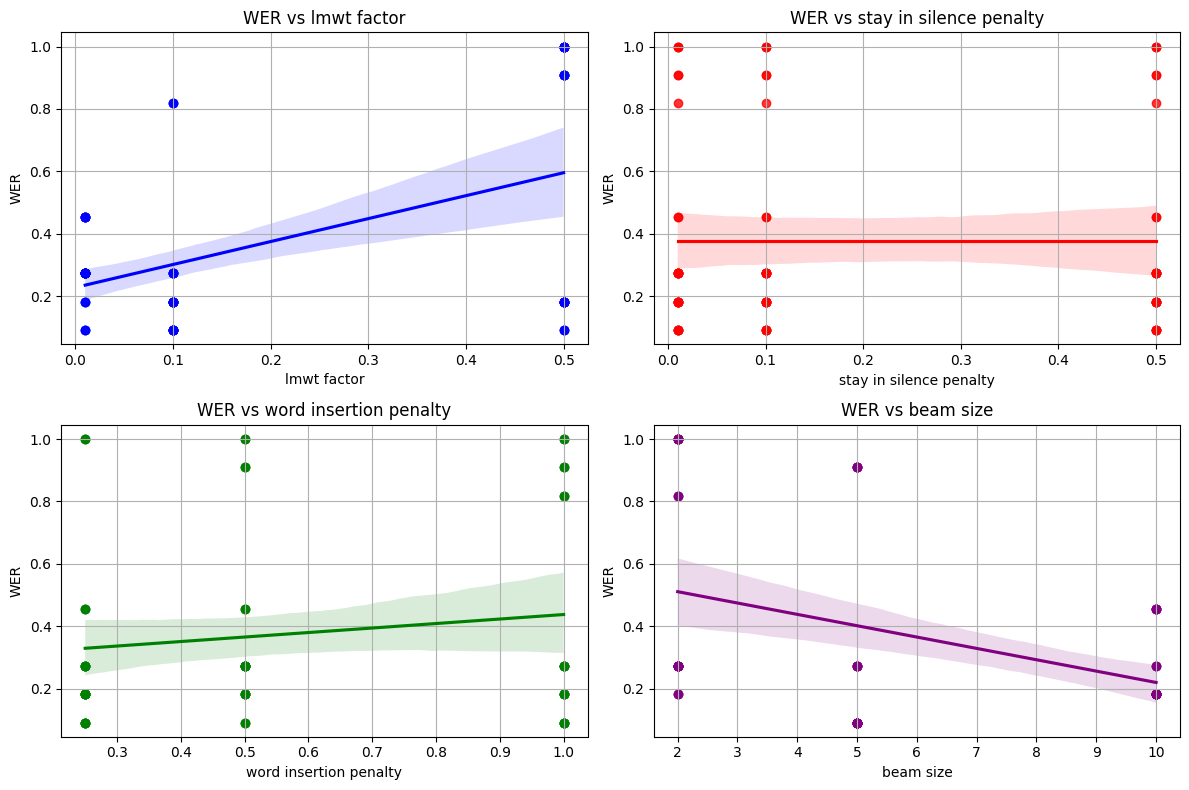

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.regplot(x="lmwt_factor", y="wer", data=results_df, color="blue")
plt.title("WER vs lmwt factor")
plt.xlabel("lmwt factor")
plt.ylabel("WER")
plt.grid(True)

plt.subplot(2, 2, 2)
sns.regplot(x="stay_in_silence_penalty", y="wer", data=results_df, color="red")
plt.title("WER vs stay in silence penalty")
plt.xlabel("stay in silence penalty")
plt.ylabel("WER")
plt.grid(True)

plt.subplot(2, 2, 3)
sns.regplot(x="word_insertion_penalty", y="wer", data=results_df, color="green")
plt.title("WER vs word insertion penalty")
plt.xlabel("word insertion penalty")
plt.ylabel("WER")
plt.grid(True)

plt.subplot(2, 2, 4)
sns.regplot(x="beam_size", y="wer", data=results_df, color="purple")
plt.title("WER vs beam size")
plt.xlabel("beam size")
plt.ylabel("WER")
plt.grid(True)

plt.tight_layout()
plt.show()

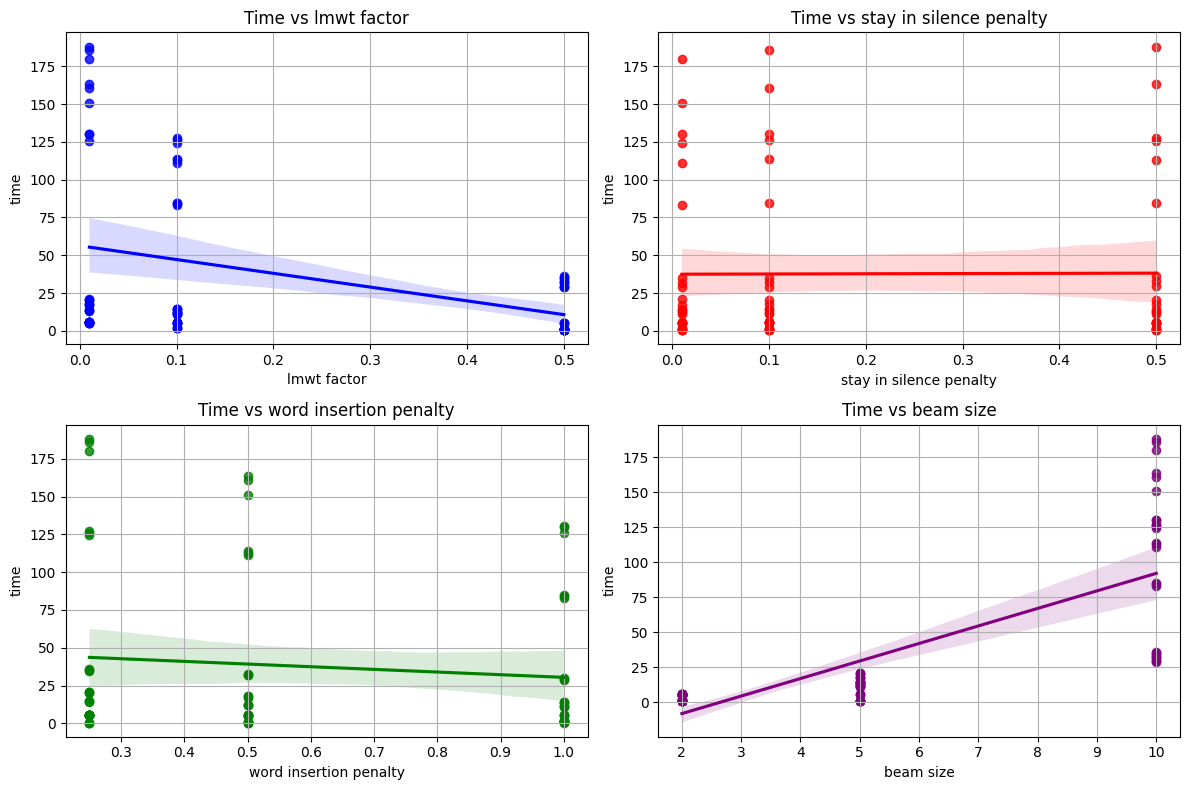

In [61]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.regplot(x="lmwt_factor", y="time", data=results_df, color="blue")
plt.title("Time vs lmwt factor")
plt.xlabel("lmwt factor")
plt.ylabel("time")
plt.grid(True)

plt.subplot(2, 2, 2)
sns.regplot(x="stay_in_silence_penalty", y="time", data=results_df, color="red")
plt.title("Time vs stay in silence penalty")
plt.xlabel("stay in silence penalty")
plt.ylabel("time")
plt.grid(True)

plt.subplot(2, 2, 3)
sns.regplot(x="word_insertion_penalty", y="time", data=results_df, color="green")
plt.title("Time vs word insertion penalty")
plt.xlabel("word insertion penalty")
plt.ylabel("time")
plt.grid(True)

plt.subplot(2, 2, 4)
sns.regplot(x="beam_size", y="time", data=results_df, color="purple")
plt.title("Time vs beam size")
plt.xlabel("beam size")
plt.ylabel("time")
plt.grid(True)

plt.tight_layout()
plt.show()

In [67]:
optimal_parameters = results_df.sort_values(['wer', 'time'], ascending=[True, True]).iloc[0][["lmwt_factor", "stay_in_silence_penalty", "word_insertion_penalty", "beam_size"]]
opt_lmwt_factor, opt_stay_in_silence_penalty, opt_word_insertion_penalty, opt_beam_size = optimal_parameters
print(f"Оптимальный lmwt factor: {opt_lmwt_factor}\nОптимальный stay in silence penalty: {opt_stay_in_silence_penalty}\nОптимальный word insertion penalty: {opt_word_insertion_penalty}\nОптимальный beam size: {opt_beam_size}")

Оптимальный lmwt factor: 0.5
Оптимальный stay in silence penalty: 0.5
Оптимальный word insertion penalty: 0.25
Оптимальный beam size: 5.0


In [73]:
results_df.sort_values(['wer', 'time'], ascending=[True, True])

,lmwt_factor,stay_in_silence_penalty,word_insertion_penalty,beam_size,wer,time
76,0.5,0.50,0.25,5,0.090909,5.355247
58,0.5,0.01,0.25,5,0.090909,5.422096
67,0.5,0.10,0.25,5,0.090909,5.432987
52,0.1,0.50,1.00,5,0.090909,11.031374
34,0.1,0.01,1.00,5,0.090909,11.163718
...,...,...,...,...,...,...
68,0.5,0.10,0.25,2,1.000000,0.484742
77,0.5,0.50,0.25,2,1.000000,0.486175
65,0.5,0.10,0.50,2,1.000000,0.486339
62,0.5,0.01,1.00,2,1.000000,0.575917


# Дополнительное задание (2 балла)
Декодируйте всю коллекцию am_nlogprobs с подобраными ранее параметрами и посчитайте WER на этой выборке


In [69]:
t_fst = create_t_wfst()
l_fst = create_Lwfst_from_file(stay_in_silence_penalty=opt_stay_in_silence_penalty, word_insertion_penalty=opt_word_insertion_penalty)
lm = kenlmLikeWFST(kenlm.LanguageModel('resources/lab4/3gram.arpa'), lmwt_factor=opt_lmwt_factor)
ASR = BeamSearcher(am2phone_mapping=AM_PHONES,
                graph=OnTheFlyCompose([t_fst, l_fst, lm]),
                beam_size=opt_beam_size)

decoded_am_nlogprobs = {"file_name": [],
                        "hypothesis": [],
                        "reference": [],
                        "wer": []}

for file_name, nlogprobs in am_nlogprobs.items():
    with open(file_name + ".TXT") as f:
        ref = ' '.join(f.read().replace('.', ' ').split()[2:])
    hyp = ASR.decode(nlogprobs)

    decoded_am_nlogprobs["file_name"].append(file_name + ".TXT")
    decoded_am_nlogprobs["hypothesis"].append(' '.join(hyp.words))
    decoded_am_nlogprobs["reference"].append(ref)
    decoded_am_nlogprobs["wer"].append(jiwer.wer(ref, ' '.join(hyp.words)))

Loading the LM will be faster if you build a binary file.
Reading /home/karysheva@ad.speechpro.com/Документы/ITMO/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-597.1168329682027, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5c9c757770>)). Mean score -597.12. Max -597.12: 100%|██████████| 198/198 [00:05<00:00, 36.01it/s]


Found 1 hypotheses


1 hyps. Best Hypothesis(score=156.32482536024503, time=180, words=["don't", 'ask', 'me'], state=(0, 8568, <kenlm.State object at 0x7f5c9c1822b0>)). Mean score 156.32. Max 156.32: 100%|██████████| 181/181 [00:01<00:00, 97.62it/s]


Found 1 hypotheses


1 hyps. Best Hypothesis(score=380.7907087075231, time=247, words=['his', 'cafeteria'], state=(0, 14550, <kenlm.State object at 0x7f5c6ab235f0>)). Mean score 380.79. Max 380.79: 100%|██████████| 248/248 [00:01<00:00, 142.75it/s]    


Found 1 hypotheses


1 hyps. Best Hypothesis(score=200.279730058128, time=174, words=['the', 'reasons'], state=(0, 13387, <kenlm.State object at 0x7f5c9d771bf0>)). Mean score 200.28. Max 200.28: 100%|██████████| 175/175 [00:01<00:00, 100.17it/s]    


Found 1 hypotheses


1 hyps. Best Hypothesis(score=575.7387427421547, time=186, words=[], state=(0, 24657, <kenlm.State object at 0x7f5c6adba630>)). Mean score 575.74. Max 575.74: 100%|██████████| 187/187 [00:00<00:00, 247.58it/s]


Found 1 hypotheses


1 hyps. Best Hypothesis(score=343.73055703711003, time=164, words=[], state=(0, 23411, <kenlm.State object at 0x7f5c6abc1eb0>)). Mean score 343.73. Max 343.73: 100%|██████████| 165/165 [00:00<00:00, 204.59it/s]


Found 1 hypotheses


3 hyps. Best Hypothesis(score=-192.986163779528, time=153, words=['put', 'the', 'butcher', 'bought', 'table', 'a'], state=(0, 20851, <kenlm.State object at 0x7f5c6a6185f0>)). Mean score -190.29. Max -188.02: 100%|██████████| 154/154 [00:03<00:00, 41.55it/s]  


Found 3 hypotheses


1 hyps. Best Hypothesis(score=561.300020918151, time=175, words=[], state=(0, 9885, <kenlm.State object at 0x7f5c6abe7bf0>)). Mean score 561.30. Max 561.30: 100%|██████████| 176/176 [00:00<00:00, 220.26it/s]   


Found 1 hypotheses


1 hyps. Best Hypothesis(score=414.097887623975, time=166, words=['her', 'wardrobe'], state=(0, 6489, <kenlm.State object at 0x7f5c6a55b970>)). Mean score 414.10. Max 414.10: 100%|██████████| 167/167 [00:02<00:00, 56.87it/s]     


Found 1 hypotheses


1 hyps. Best Hypothesis(score=398.8444659893139, time=121, words=[], state=(0, 10304, <kenlm.State object at 0x7f5c6a6e3e70>)). Mean score 398.84. Max 398.84: 100%|██████████| 122/122 [00:00<00:00, 165.82it/s]


Found 1 hypotheses


1 hyps. Best Hypothesis(score=530.1482705597505, time=262, words=['she', 'head', 'your', 'are'], state=(0, 175, <kenlm.State object at 0x7f5c6a5de130>)). Mean score 530.15. Max 530.15: 100%|██████████| 263/263 [00:02<00:00, 110.37it/s]  


Found 1 hypotheses


1 hyps. Best Hypothesis(score=404.6752162687522, time=206, words=["don't", 'ask', 'meeting', 'care'], state=(0, 26240, <kenlm.State object at 0x7f5c6a21dff0>)). Mean score 404.68. Max 404.68: 100%|██████████| 207/207 [00:02<00:00, 85.53it/s]    


Found 1 hypotheses


1 hyps. Best Hypothesis(score=1022.1625528709536, time=219, words=[], state=(0, 15684, <kenlm.State object at 0x7f5c6a39e070>)). Mean score 1022.16. Max 1022.16: 100%|██████████| 220/220 [00:00<00:00, 613.61it/s]


Found 1 hypotheses


1 hyps. Best Hypothesis(score=792.3594160160399, time=228, words=['how'], state=(0, 34081, <kenlm.State object at 0x7f5c6a2ae7b0>)). Mean score 792.36. Max 792.36: 100%|██████████| 229/229 [00:01<00:00, 217.96it/s]


Found 1 hypotheses


1 hyps. Best Hypothesis(score=1762.0802952528168, time=370, words=[], state=(0, 13480, <kenlm.State object at 0x7f5c6a21dff0>)). Mean score 1762.08. Max 1762.08: 100%|██████████| 371/371 [00:00<00:00, 623.54it/s]


Found 1 hypotheses


1 hyps. Best Hypothesis(score=569.4102413859541, time=135, words=[], state=(0, 21385, <kenlm.State object at 0x7f5c80a37570>)). Mean score 569.41. Max 569.41: 100%|██████████| 136/136 [00:00<00:00, 322.36it/s]


Found 1 hypotheses


1 hyps. Best Hypothesis(score=809.4836139234093, time=220, words=['the', 'morning'], state=(0, 14100, <kenlm.State object at 0x7f5c6a3f0bf0>)). Mean score 809.48. Max 809.48: 100%|██████████| 221/221 [00:02<00:00, 108.77it/s] 


Found 1 hypotheses


1 hyps. Best Hypothesis(score=721.1591267228105, time=209, words=[], state=(0, 5191, <kenlm.State object at 0x7f5c6a124b30>)). Mean score 721.16. Max 721.16: 100%|██████████| 210/210 [00:00<00:00, 359.38it/s] 


Found 1 hypotheses


1 hyps. Best Hypothesis(score=-639.9125354743285, time=200, words=["don't", 'do', "charlie's", 'shut', 'early', 'dishes'], state=(0, 0, <kenlm.State object at 0x7f5c69f651b0>)). Mean score -639.91. Max -639.91: 100%|██████████| 201/201 [00:04<00:00, 48.01it/s]


Found 1 hypotheses


1 hyps. Best Hypothesis(score=675.6506395978564, time=191, words=[], state=(0, 7495, <kenlm.State object at 0x7f5cb6712e70>)). Mean score 675.65. Max 675.65: 100%|██████████| 192/192 [00:00<00:00, 311.87it/s]


Found 1 hypotheses


1 hyps. Best Hypothesis(score=820.947533040944, time=188, words=['she', 'had'], state=(0, 8547, <kenlm.State object at 0x7f5c6a1ff970>)). Mean score 820.95. Max 820.95: 100%|██████████| 189/189 [00:00<00:00, 234.09it/s]


Found 1 hypotheses


1 hyps. Best Hypothesis(score=135.98397113972243, time=146, words=["don't", 'ask', 'meeting', 'kerosene'], state=(0, 1418, <kenlm.State object at 0x7f5c6a1d2d70>)). Mean score 135.98. Max 135.98: 100%|██████████| 147/147 [00:02<00:00, 68.19it/s] 


Found 1 hypotheses


1 hyps. Best Hypothesis(score=200.22930575286486, time=274, words=['in', 'wage', 'negotiations', 'these', 'necessity'], state=(0, 2883, <kenlm.State object at 0x7f5c69e74df0>)). Mean score 200.23. Max 200.23: 100%|██████████| 275/275 [00:02<00:00, 117.36it/s]  


Found 1 hypotheses


1 hyps. Best Hypothesis(score=624.8907795547282, time=168, words=['he'], state=(0, 34722, <kenlm.State object at 0x7f5c6a2356b0>)). Mean score 624.89. Max 624.89: 100%|██████████| 169/169 [00:00<00:00, 238.14it/s] 


Found 1 hypotheses


1 hyps. Best Hypothesis(score=734.5923877352063, time=208, words=[], state=(0, 19288, <kenlm.State object at 0x7f5c6a310270>)). Mean score 734.59. Max 734.59: 100%|██████████| 209/209 [00:00<00:00, 686.99it/s]


Found 1 hypotheses


1 hyps. Best Hypothesis(score=384.28510111395303, time=144, words=['are'], state=(0, 21603, <kenlm.State object at 0x7f5c69e6d3b0>)). Mean score 384.29. Max 384.29: 100%|██████████| 145/145 [00:02<00:00, 53.24it/s] 


Found 1 hypotheses


1 hyps. Best Hypothesis(score=-55.616537827758634, time=108, words=['a', 'small', 'boy', 'put'], state=(0, 10016, <kenlm.State object at 0x7f5c69ba5f70>)). Mean score -55.62. Max -55.62: 100%|██████████| 109/109 [00:04<00:00, 26.52it/s]


Found 1 hypotheses


19 hyps. Best Hypothesis(score=-351.62914247335334, time=123, words=['a', 'chosen', 'few', 'would', 'be', 'come'], state=(0, 13654, <kenlm.State object at 0x7f5c69b719f0>)). Mean score -347.68. Max -347.18: 100%|██████████| 124/124 [00:04<00:00, 30.25it/s]


Found 19 hypotheses


1 hyps. Best Hypothesis(score=-280.69509480463, time=174, words=['only', 'the', 'most', 'accomplished', 'participate', "ain't"], state=(0, 23780, <kenlm.State object at 0x7f5c698c6ff0>)). Mean score -280.70. Max -280.70: 100%|██████████| 175/175 [00:06<00:00, 26.11it/s]    


Found 1 hypotheses


1 hyps. Best Hypothesis(score=447.20697220782426, time=189, words=['the', 'fish', 'began', 'to'], state=(0, 1061, <kenlm.State object at 0x7f5c69721630>)). Mean score 447.21. Max 447.21: 100%|██████████| 190/190 [00:01<00:00, 99.01it/s]


Found 1 hypotheses


1 hyps. Best Hypothesis(score=-371.9671386124129, time=185, words=['she', 'head', 'your', 'dark', 'suit', 'together', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f5c6974dab0>)). Mean score -371.97. Max -371.97: 100%|██████████| 186/186 [00:05<00:00, 34.92it/s] 


Found 1 hypotheses


1 hyps. Best Hypothesis(score=265.3131340213664, time=171, words=["don't", 'ask', 'me'], state=(0, 8568, <kenlm.State object at 0x7f5c69abf530>)). Mean score 265.31. Max 265.31: 100%|██████████| 172/172 [00:01<00:00, 98.47it/s]


Found 1 hypotheses


1 hyps. Best Hypothesis(score=543.9322195281043, time=171, words=[], state=(0, 7985, <kenlm.State object at 0x7f5c69ed48f0>)). Mean score 543.93. Max 543.93: 100%|██████████| 172/172 [00:00<00:00, 438.20it/s]


Found 1 hypotheses


2 hyps. Best Hypothesis(score=41.7652395224446, time=145, words=['my', 'for', 'thermometer', 'important', 'six'], state=(0, 28068, <kenlm.State object at 0x7f5c6954b470>)). Mean score 44.17. Max 46.58: 100%|██████████| 146/146 [00:03<00:00, 37.79it/s]    


Found 2 hypotheses


1 hyps. Best Hypothesis(score=561.4459786840472, time=303, words=['here', 'he', 'is', 'quite', 'persuasively'], state=(0, 34616, <kenlm.State object at 0x7f5c69555370>)). Mean score 561.45. Max 561.45: 100%|██████████| 304/304 [00:05<00:00, 58.79it/s]   


Found 1 hypotheses


27 hyps. Best Hypothesis(score=-431.0849365093908, time=144, words=['the', "cat's", 'meow', 'always', 'hurts', 'my', 'use'], state=(0, 0, <kenlm.State object at 0x7f5c694f27f0>)). Mean score -426.75. Max -426.59: 100%|██████████| 145/145 [00:10<00:00, 13.59it/s]


Found 1 hypotheses


1 hyps. Best Hypothesis(score=737.4065654565613, time=194, words=[], state=(0, 5705, <kenlm.State object at 0x7f5c698d35f0>)). Mean score 737.41. Max 737.41: 100%|██████████| 195/195 [00:00<00:00, 287.19it/s]


Found 1 hypotheses


1 hyps. Best Hypothesis(score=733.6560709906366, time=288, words=['each', 'untimely', 'think', 'come'], state=(0, 35267, <kenlm.State object at 0x7f5c69c7f4b0>)). Mean score 733.66. Max 733.66: 100%|██████████| 289/289 [00:04<00:00, 66.99it/s]    


Found 1 hypotheses


1 hyps. Best Hypothesis(score=364.9226743142749, time=149, words=[], state=(0, 5090, <kenlm.State object at 0x7f5c696b0770>)). Mean score 364.92. Max 364.92: 100%|██████████| 150/150 [00:00<00:00, 739.64it/s]


Found 1 hypotheses


1 hyps. Best Hypothesis(score=446.0615255501414, time=159, words=[], state=(0, 36329, <kenlm.State object at 0x7f5c698d35f0>)). Mean score 446.06. Max 446.06: 100%|██████████| 160/160 [00:00<00:00, 209.56it/s]

Found 1 hypotheses


In [77]:
decoded_am_nlogprobs_df = pd.DataFrame.from_dict(decoded_am_nlogprobs)
print(f"Средний WER на выборке: {np.mean(decoded_am_nlogprobs_df["wer"])}\n")
display(decoded_am_nlogprobs_df.sort_values('wer', ascending=True))

Средний WER на выборке: 0.8595034826284825



,file_name,hypothesis,reference,wer
0,timit/data/TEST/DR1/FAKS0/SA1.TXT,she had your dark suit in greasy wash water al...,She had your dark suit in greasy wash water al...,0.090909
35,timit/data/TEST/DR1/FJEM0/SX184.TXT,the cat's meow always hurts my use,The cat's meow always hurts my ears,0.285714
30,timit/data/TEST/DR1/FJEM0/SA1.TXT,she head your dark suit together wash water al...,She had your dark suit in greasy wash water al...,0.363636
28,timit/data/TEST/DR1/FELC0/SX36.TXT,only the most accomplished participate ain't,Only the most accomplished artists obtain popu...,0.571429
6,timit/data/TEST/DR1/FAKS0/SX223.TXT,put the butcher bought table a,Put the butcher block table in the garage,0.625000
26,timit/data/TEST/DR1/FELC0/SX216.TXT,a small boy put,The small boy put the worm on the hook,0.666667
29,timit/data/TEST/DR1/FELC0/SX396.TXT,the fish began to,The fish began to leap frantically on the surf...,0.769231
31,timit/data/TEST/DR1/FJEM0/SA2.TXT,don't ask me,Don't ask me to carry an oily rag like that,0.800000
18,timit/data/TEST/DR1/FDAC1/SX34.TXT,don't do charlie's shut early dishes,Don't do Charlie's dirty dishes,0.800000
1,timit/data/TEST/DR1/FAKS0/SA2.TXT,don't ask me,Don't ask me to carry an oily rag like that,0.800000
